# OU jump 12

In [1]:
import pandas as pd
import numpy as np
import random
from numpy.random import RandomState
from scipy import stats
from scipy.optimize import minimize
import scipy
import os
os.environ['R_HOME'] = '/Library/Frameworks/R.framework/Versions/4.1/Resources/'
import rpy2
from rpy2.robjects.packages import importr
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage
import datetime
from rpy2.robjects.vectors import FloatVector
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression

real_data_folder = "/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Data/sp500_mixed_period/"
np.random.seed(12001)


# Define the model that generates pair simulations.
yuima = importr("yuima")
n_jumpou_NIG_sim_string = """
n_jumpou_NIG = function(random_seed, num_sim,
                        mu11, mu12, mu21, mu22, 
                        sigma11, sigma12, sigma21, sigma22,
                        j11, j12, j21, j22,
                        alpha, beta1, beta2, delta0, mu1, mu2, 
                        lambda11, lambda12, lambda21, lambda22,
                        xinit_vec, T0, T, length){
  
  set.seed(random_seed)
  
  drift = c("mu11*t-mu12*X1", "mu21*t-mu22*X2")
  diffusion = matrix(c("exp(sigma11)", "exp(sigma12)", "exp(sigma21)", "exp(sigma22)"), 2, 2, byrow=TRUE)
  jumpcoef = matrix(c("j11", "j12", "j21", "j22"), 2, 2, byrow=TRUE) 
  
  alpha = alpha
  beta = c(beta1, beta2)
  delta0 = delta0
  mu = c(mu1, mu2)
  Lambda = matrix(c(lambda11, lambda12, lambda21, lambda22), 2, 2, byrow=TRUE)
  
  ou_model = setModel(drift=drift, diffusion=diffusion, jump.coeff=jumpcoef, 
                      measure.type="code",
                      measure=list(df="rNIG(z, alpha, beta, delta0, mu, Lambda)"), 
                      time.variable = "t",
                      state.var=c("X1","X2"), solve.variable=c("X1","X2"))
  newsamp = setSampling(Initial=T0, Terminal=T, n=length)
  
  n_sim_data = data.frame(matrix(nrow=length+1, ncol=2*num_sim))
  for (i in 1:num_sim){
    jumpou_sim = simulate(ou_model, 
                          true.par=list(
                            mu11=mu11, mu12=mu12, mu21=mu21, mu22=mu22, 
                            sigma11=sigma11, sigma12=sigma12, sigma21=sigma21, sigma22=sigma22,
                            j11=j11, j12=j12, j21=j21, j22=j22,
                            alpha=alpha, beta=beta, delta0=delta0, mu=mu, Lambda=Lambda), 
                          xinit=xinit_vec[[i]], sampling=newsamp)
    original_data = jumpou_sim@data@original.data
    one_sim_jumpou = data.frame(original_data[,1], original_data[,2])
    colnames(one_sim_jumpou) = c('series1', 'series2')
    n_sim_data[, (2*i-1):(2*i)] = one_sim_jumpou
  }
  return(n_sim_data)
}
"""

n_jumpou_NIG_sim = SignatureTranslatedAnonymousPackage(n_jumpou_NIG_sim_string, "n_jumpou_NIG_sim")
def n_jumpou_simulation(random_seed, num_sim,
                        mu11, mu12, mu21, mu22, 
                        sigma11, sigma12, sigma21, sigma22,
                        j11, j12, j21, j22,
                        alpha, beta1, beta2, delta0, mu1, mu2, 
                        lambda11, lambda12, lambda21, lambda22,
                        xinit_vec, T0, T, length):

    n_sim_data = pd.DataFrame(
        n_jumpou_NIG_sim.n_jumpou_NIG(random_seed, num_sim,
                                      mu11, mu12, mu21, mu22, 
                                      sigma11, sigma12, sigma21, sigma22,
                                      j11, j12, j21, j22,
                                      alpha, beta1, beta2, delta0, mu1, mu2, 
                                      lambda11, lambda12, lambda21, lambda22,
                                      xinit_vec, T0, T, length)).transpose()
    return n_sim_data


def price_to_log_price(n_price):
    return(np.log(n_price))

def log_price_to_price(n_log_price):
    return(np.exp(n_log_price))

def price_to_return(n_price):
    n_return = pd.DataFrame()
    for i in range(n_price.shape[1]):
        ith_column_price_series = n_price.iloc[:, i]
        n_return = pd.concat([n_return, 100 * (np.log(ith_column_price_series[1:].values) - np.log(ith_column_price_series[:-1]))], axis=1)
    return n_return

def log_price_to_return(n_log_price):
    n_real_return = pd.DataFrame()
    for i in range(n_log_price.shape[1]):
        ith_column_price_series = n_log_price.iloc[:, i]
        n_real_return = pd.concat([n_real_return, 100 * (ith_column_price_series[1:].values - ith_column_price_series[:-1])], axis=1)
    return n_real_return


def cross_corr_coef(lag_time_series, lead_time_series, lag):
    # calculate the cross correlation between two time series
    # if the result is not zero, then 'lead_time_series' leads 'lag_time_series'
    lag_time_series = lag_time_series.iloc[lag:]
    corr_coef = np.corrcoef(lag_time_series, lead_time_series.iloc[0:((lead_time_series.size)-lag)])[0][1]
    return corr_coef

def cal_stats(n_return, n_price):
    
    return_series1 = n_return.iloc[:, ::2]
    return_series2 = n_return.iloc[:, 1::2]
    price_series1 = n_price.iloc[:, ::2]
    price_series2 = n_price.iloc[:, 1::2]
    sq_return_series1 = return_series1**2
    sq_return_series2 = return_series2**2

    
    mean1 = return_series1.mean(axis=0).values
    sd1 = return_series1.std(axis=0).values
    skew1 = return_series1.skew(axis=0).values
    kurtosis1 = return_series1.kurtosis(axis=0).values
       
    
    mean2 = return_series2.mean(axis=0).values
    sd2 = return_series2.std(axis=0).values
    skew2 = return_series1.skew(axis=0).values
    kurtosis2 = return_series2.kurtosis(axis=0).values
    
    
    # Autocorrelation of the 2 return series with 3 lags respectively
    autocorr1_lag_1 = return_series1.apply(lambda x: x.autocorr(lag=1))
    autocorr1_lag_2 = return_series1.apply(lambda x: x.autocorr(lag=2))
    autocorr1_lag_3 = return_series1.apply(lambda x: x.autocorr(lag=3))
    autocorr2_lag_1 = return_series2.apply(lambda x: x.autocorr(lag=1)) 
    autocorr2_lag_2 = return_series2.apply(lambda x: x.autocorr(lag=2)) 
    autocorr2_lag_3 = return_series2.apply(lambda x: x.autocorr(lag=3)) 
    
    
    # Cross-correlation between return series
    corr_ts1_lag_0 = []
    corr_ts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_ts1_lag_2 = []
    corr_ts1_lag_3 = []
    corr_ts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_ts2_lag_2 = []
    corr_ts2_lag_3 = []
    for i in range(int(real_price.shape[1]/2)):
        corr_ts1_lag_0.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 0))
        corr_ts1_lag_1.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 1))
        corr_ts1_lag_2.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 2))
        corr_ts1_lag_3.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 3))
        corr_ts2_lag_1.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 1))
        corr_ts2_lag_2.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 2))
        corr_ts2_lag_3.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 3))
    corr_ts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_ts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_ts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_ts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_ts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_ts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_ts2_lag_3 = pd.Series(corr_ts2_lag_3)
    
    
    # Autocorrelation of the 2 squared returns with 3 lags respectively
    autocorr_sqreturn_1_lag_1 = sq_return_series1.apply(lambda x: x.autocorr(lag=1))
    autocorr_sqreturn_1_lag_2 = sq_return_series1.apply(lambda x: x.autocorr(lag=2))
    autocorr_sqreturn_1_lag_3 = sq_return_series1.apply(lambda x: x.autocorr(lag=3))
    autocorr_sqreturn_2_lag_1 = sq_return_series2.apply(lambda x: x.autocorr(lag=1)) 
    autocorr_sqreturn_2_lag_2 = sq_return_series2.apply(lambda x: x.autocorr(lag=2)) 
    autocorr_sqreturn_2_lag_3 = sq_return_series2.apply(lambda x: x.autocorr(lag=3))
    
    
    stats_data = pd.DataFrame([mean1, mean2, sd1, sd2, 
                               skew1, skew2, kurtosis1, kurtosis2, 
                               autocorr1_lag_1, autocorr1_lag_2, autocorr1_lag_3,
                               autocorr2_lag_1, autocorr2_lag_2, autocorr2_lag_3,
                               corr_ts1_lag_0, 
                               corr_ts1_lag_1, corr_ts1_lag_2, corr_ts1_lag_3,
                               corr_ts2_lag_1, corr_ts2_lag_2, corr_ts2_lag_3,
                               autocorr_sqreturn_1_lag_1, autocorr_sqreturn_1_lag_2, autocorr_sqreturn_1_lag_3,
                               autocorr_sqreturn_2_lag_1, autocorr_sqreturn_2_lag_2, autocorr_sqreturn_2_lag_3])
    stats_data = stats_data.transpose()
    stats_data.columns = [
        'return_mean1', 'return_mean2',
        'return_sd1', 'return_sd2',
        'return_skew1', 'return_skew2',
        'return_kurtosis1', 'return_kurtosis2',
        'return_autocorrelation_ts1_lag1', 'return_autocorrelation_ts1_lag2', 'return_autocorrelation_ts1_lag3',
        'return_autocorrelation_ts2_lag1', 'return_autocorrelation_ts2_lag2', 'return_autocorrelation_ts2_lag3',
        'return_correlation_ts1_lag_0',
        'return_correlation_ts1_lag_1', 'return_correlation_ts1_lag_2', 'return_correlation_ts1_lag_3',
        'return_correlation_ts2_lag_1', 'return_correlation_ts2_lag_2', 'return_correlation_ts2_lag_3',
        'sqreturn_autocorrelation_ts1_lag1', 'sqreturn_autocorrelation_ts1_lag2', 'sqreturn_autocorrelation_ts1_lag3',
        'sqreturn_autocorrelation_ts2_lag1', 'sqreturn_autocorrelation_ts2_lag2', 'sqreturn_autocorrelation_ts2_lag3']
    
    return stats_data



def loss_function(params):
    """n_real_stats is a global amount calculated outside the function"""
    params = FloatVector(params)
    print(params)
    moment_loss = pd.DataFrame().reindex_like(real_stats)
    
    n_sim_log_price = n_jumpou_simulation(
        random_seed=int(np.random.randint(low=0, high=980608, size=(1,))), num_sim=num_sim,
        mu11=params[0], mu12=params[1], 
        mu21=params[2], mu22=params[3], 
        sigma11=params[4], sigma12=params[5], 
        sigma21=params[6], sigma22=params[7],
        j11=params[8], j12=params[9], 
        j21=params[10], j22=params[11],
        alpha=alpha, 
        beta1=beta1, beta2=beta2, 
        delta0=params[12], 
        mu1=mu1, mu2=mu2, 
        lambda11=lambda11, lambda12=lambda12, 
        lambda21=lambda21, lambda22=lambda22,
        xinit_vec=xinit_vec, T0=T0, T=T, length=length)
    
    n_sim_price = log_price_to_price(n_sim_log_price)
    n_sim_return = price_to_return(n_sim_price)
    n_sim_stats = cal_stats(n_sim_return, n_sim_price)


    moment_loss = (n_real_stats - n_sim_stats)**2
    mse = np.sum(moment_loss)
    
    #mse[0] = mse[0]*10 # return_mean1
    #mse[1] = mse[1]*10 # return_mean2
    #mse[2] = mse[2]*10 # return_sd1
    #mse[3] = mse[3]*10 # return_sd2
    #mse[4] = mse[4]*10 # return_skew1
    #mse[5] = mse[5]*10 # return_skew2    
    #mse[6] = mse[6]/3 # return_kurtosis1
    #mse[7] = mse[7]/5 # return_kurtosis2 
    
    #mse[8] = mse[8]*1000 # return_autocorrelation_ts1_lag1
    #mse[11] = mse[11]*1000 # return_autocorrelation_ts2_lag1
    
    #mse[14] = mse[14]*10 # cross_corr
    #mse[15] = mse[15]*1000 # cross_corr_ts1_lag1
    #mse[18] = mse[18]*1000 # cross_corr_ts2_lag1
    
    #mse[21] = mse[21]*1000 # sq_return_autocorrelation_ts1_lag1
    #mse[24] = mse[24]*1000 # sq_return_autocorrelation_ts2_lag1
    
    sum_mse = np.sum(mse)

    print(mse)
    print(sum_mse)
    print('----------')

    return sum_mse



real_price = pd.read_csv(real_data_folder + "pair_price_mixed_period_calibration.csv", index_col=[0])
real_log_price = price_to_log_price(n_price=real_price)
real_return = pd.read_csv(real_data_folder + "pair_return_mixed_period_calibration.csv", index_col=[0])
real_stats = cal_stats(n_return=real_return, n_price=real_price)


xinit_vec = []
for i in range(int(real_log_price.shape[1]/2)):
    init_pair_log_price = [real_log_price.iloc[0, 2*i], real_log_price.iloc[0, 2*i+1]]
    init_pair_log_price = FloatVector(init_pair_log_price)
    xinit_vec.append(init_pair_log_price)
    
num_sim, T0, T, length = real_stats.shape[0], 0, 1, real_price.shape[0]

n_real_stats = real_stats


alpha = 2
beta1 = 0
beta2 = 0
#delta0 = 0.55
mu1 = 0
mu2 = 0
lambda11 = 1
lambda12 = 0
lambda21 = 0
lambda22 = 1


initial0 = [1, 1, 1, 1,
            -1, -1, -1, -1,
            0.1, 0.1, 0.1, 0.1, 0.5]

begin_time = datetime.datetime.now()
res = minimize(loss_function, initial0, method='Powell',
               tol=1e-6, options={'disp': True},
               bounds=[(None, None), (None, None), (None, None), (None, None),
                       (None, None), (None, None), (None, None), (None, None),
                       (None, None), (None, None), (None, None), (None, None),
                       [0, None]])
print(res.x)

time = datetime.datetime.now() - begin_time
print(time)

params = (res.x)
loss = loss_function((params))
print(loss)

 [1]  1.0  1.0  1.0  1.0 -1.0 -1.0 -1.0 -1.0  0.1  0.1  0.1  0.1

return_mean1                         10.759368
return_mean2                          9.914527
return_sd1                           31.707023
return_sd2                           29.652004
return_skew1                         11.016472
return_skew2                         11.016472
return_kurtosis1                     34.732827
return_kurtosis2                     43.346064
return_autocorrelation_ts1_lag1       8.437791
return_autocorrelation_ts1_lag2       0.008484
return_autocorrelation_ts1_lag3       0.008627
return_autocorrelation_ts2_lag1       8.203249
return_autocorrelation_ts2_lag2       0.007801
return_autocorrelation_ts2_lag3       0.007677
return_correlation_ts1_lag_0          4.890169
return_correlation_ts1_lag_1          8.301244
return_correlation_ts1_lag_2          0.007511
return_correlation_ts1_lag_3          0.009142
return_correlation_ts2_lag_1          8.301804
return_correlation_ts2_lag_2          0.0

return_mean1                          6.616654
return_mean2                          9.678859
return_sd1                           32.422760
return_sd2                           30.076401
return_skew1                         11.503160
return_skew2                         11.503160
return_kurtosis1                     34.709587
return_kurtosis2                     42.998126
return_autocorrelation_ts1_lag1       8.802945
return_autocorrelation_ts1_lag2       0.011196
return_autocorrelation_ts1_lag3       0.007710
return_autocorrelation_ts2_lag1       8.186043
return_autocorrelation_ts2_lag2       0.009578
return_autocorrelation_ts2_lag3       0.009277
return_correlation_ts1_lag_0          4.881180
return_correlation_ts1_lag_1          7.557790
return_correlation_ts1_lag_2          0.008819
return_correlation_ts1_lag_3          0.010313
return_correlation_ts2_lag_1          8.411419
return_correlation_ts2_lag_2          0.009788
return_correlation_ts2_lag_3          0.007233
sqreturn_auto

return_mean1                          6.414852
return_mean2                          9.490059
return_sd1                           32.342102
return_sd2                           29.997877
return_skew1                         12.053905
return_skew2                         12.053905
return_kurtosis1                     35.037654
return_kurtosis2                     44.108728
return_autocorrelation_ts1_lag1      10.645884
return_autocorrelation_ts1_lag2       0.009856
return_autocorrelation_ts1_lag3       0.008695
return_autocorrelation_ts2_lag1       8.779586
return_autocorrelation_ts2_lag2       0.008823
return_autocorrelation_ts2_lag3       0.008719
return_correlation_ts1_lag_0          4.881109
return_correlation_ts1_lag_1          8.118153
return_correlation_ts1_lag_2          0.008451
return_correlation_ts1_lag_3          0.008524
return_correlation_ts2_lag_1         10.453283
return_correlation_ts2_lag_2          0.010374
return_correlation_ts2_lag_3          0.008027
sqreturn_auto

return_mean1                         43.645235
return_mean2                          9.894378
return_sd1                           32.995331
return_sd2                           30.055243
return_skew1                         11.804095
return_skew2                         11.804095
return_kurtosis1                     35.400294
return_kurtosis2                     43.662543
return_autocorrelation_ts1_lag1      12.240758
return_autocorrelation_ts1_lag2       0.011066
return_autocorrelation_ts1_lag3       0.008687
return_autocorrelation_ts2_lag1       9.086635
return_autocorrelation_ts2_lag2       0.008532
return_autocorrelation_ts2_lag3       0.008500
return_correlation_ts1_lag_0          4.825645
return_correlation_ts1_lag_1          8.589787
return_correlation_ts1_lag_2          0.008006
return_correlation_ts1_lag_3          0.008144
return_correlation_ts2_lag_1         10.120214
return_correlation_ts2_lag_2          0.008383
return_correlation_ts2_lag_3          0.007490
sqreturn_auto

return_mean1                          2.240720
return_mean2                          9.669149
return_sd1                           31.180033
return_sd2                           29.391872
return_skew1                         11.244715
return_skew2                         11.244715
return_kurtosis1                     34.675992
return_kurtosis2                     43.269448
return_autocorrelation_ts1_lag1       9.250305
return_autocorrelation_ts1_lag2       0.010542
return_autocorrelation_ts1_lag3       0.008097
return_autocorrelation_ts2_lag1       8.960082
return_autocorrelation_ts2_lag2       0.009564
return_autocorrelation_ts2_lag3       0.008051
return_correlation_ts1_lag_0          4.890871
return_correlation_ts1_lag_1          8.459570
return_correlation_ts1_lag_2          0.010480
return_correlation_ts1_lag_3          0.009670
return_correlation_ts2_lag_1          9.320120
return_correlation_ts2_lag_2          0.009317
return_correlation_ts2_lag_3          0.007969
sqreturn_auto

return_mean1                          3.271243
return_mean2                         10.006996
return_sd1                           32.257177
return_sd2                           30.373298
return_skew1                         10.891854
return_skew2                         10.891854
return_kurtosis1                     34.282742
return_kurtosis2                     43.058078
return_autocorrelation_ts1_lag1       9.181299
return_autocorrelation_ts1_lag2       0.009509
return_autocorrelation_ts1_lag3       0.008270
return_autocorrelation_ts2_lag1       8.971422
return_autocorrelation_ts2_lag2       0.007760
return_autocorrelation_ts2_lag3       0.009117
return_correlation_ts1_lag_0          4.891105
return_correlation_ts1_lag_1          8.937468
return_correlation_ts1_lag_2          0.008499
return_correlation_ts1_lag_3          0.009606
return_correlation_ts2_lag_1          9.255123
return_correlation_ts2_lag_2          0.008621
return_correlation_ts2_lag_3          0.008375
sqreturn_auto

return_mean1                          2.922152
return_mean2                          9.596854
return_sd1                           31.713593
return_sd2                           30.096192
return_skew1                         11.771007
return_skew2                         11.771007
return_kurtosis1                     36.233915
return_kurtosis2                     44.388917
return_autocorrelation_ts1_lag1       9.227436
return_autocorrelation_ts1_lag2       0.008761
return_autocorrelation_ts1_lag3       0.007783
return_autocorrelation_ts2_lag1       8.829024
return_autocorrelation_ts2_lag2       0.009428
return_autocorrelation_ts2_lag3       0.008537
return_correlation_ts1_lag_0          4.891040
return_correlation_ts1_lag_1          8.944398
return_correlation_ts1_lag_2          0.009048
return_correlation_ts1_lag_3          0.008395
return_correlation_ts2_lag_1          8.756702
return_correlation_ts2_lag_2          0.009315
return_correlation_ts2_lag_3          0.008158
sqreturn_auto

return_mean1                          3.068189
return_mean2                          9.815081
return_sd1                           32.428045
return_sd2                           30.556020
return_skew1                         11.303677
return_skew2                         11.303677
return_kurtosis1                     34.618739
return_kurtosis2                     43.536703
return_autocorrelation_ts1_lag1       9.575304
return_autocorrelation_ts1_lag2       0.008400
return_autocorrelation_ts1_lag3       0.009239
return_autocorrelation_ts2_lag1       9.179656
return_autocorrelation_ts2_lag2       0.008264
return_autocorrelation_ts2_lag3       0.009173
return_correlation_ts1_lag_0          4.890979
return_correlation_ts1_lag_1          9.046583
return_correlation_ts1_lag_2          0.007754
return_correlation_ts1_lag_3          0.008452
return_correlation_ts2_lag_1          8.936888
return_correlation_ts2_lag_2          0.008343
return_correlation_ts2_lag_3          0.008670
sqreturn_auto

return_mean1                          3.055382
return_mean2                          5.108806
return_sd1                           32.253740
return_sd2                           31.274036
return_skew1                         12.060036
return_skew2                         12.060036
return_kurtosis1                     34.799246
return_kurtosis2                     43.659214
return_autocorrelation_ts1_lag1       9.442166
return_autocorrelation_ts1_lag2       0.008432
return_autocorrelation_ts1_lag3       0.006833
return_autocorrelation_ts2_lag1       9.744522
return_autocorrelation_ts2_lag2       0.008375
return_autocorrelation_ts2_lag3       0.008377
return_correlation_ts1_lag_0          4.879864
return_correlation_ts1_lag_1          9.276275
return_correlation_ts1_lag_2          0.007435
return_correlation_ts1_lag_3          0.008456
return_correlation_ts2_lag_1         10.111718
return_correlation_ts2_lag_2          0.008680
return_correlation_ts2_lag_3          0.007032
sqreturn_auto

return_mean1                          3.154453
return_mean2                          3.563919
return_sd1                           32.183090
return_sd2                           31.477960
return_skew1                         11.294828
return_skew2                         11.294828
return_kurtosis1                     34.652027
return_kurtosis2                     43.049183
return_autocorrelation_ts1_lag1       8.961336
return_autocorrelation_ts1_lag2       0.008811
return_autocorrelation_ts1_lag3       0.008794
return_autocorrelation_ts2_lag1       9.860438
return_autocorrelation_ts2_lag2       0.009826
return_autocorrelation_ts2_lag3       0.009511
return_correlation_ts1_lag_0          4.867513
return_correlation_ts1_lag_1          7.927685
return_correlation_ts1_lag_2          0.008600
return_correlation_ts1_lag_3          0.009876
return_correlation_ts2_lag_1          9.500229
return_correlation_ts2_lag_2          0.007840
return_correlation_ts2_lag_3          0.008566
sqreturn_auto

return_mean1                          2.798048
return_mean2                          3.436640
return_sd1                           32.064702
return_sd2                           31.296713
return_skew1                         11.860365
return_skew2                         11.860365
return_kurtosis1                     33.897979
return_kurtosis2                     43.234624
return_autocorrelation_ts1_lag1       7.854124
return_autocorrelation_ts1_lag2       0.009502
return_autocorrelation_ts1_lag3       0.008455
return_autocorrelation_ts2_lag1       8.583206
return_autocorrelation_ts2_lag2       0.009686
return_autocorrelation_ts2_lag3       0.008770
return_correlation_ts1_lag_0          4.867863
return_correlation_ts1_lag_1          8.065294
return_correlation_ts1_lag_2          0.008751
return_correlation_ts1_lag_3          0.009589
return_correlation_ts2_lag_1          8.055113
return_correlation_ts2_lag_2          0.008727
return_correlation_ts2_lag_3          0.008523
sqreturn_auto

return_mean1                          3.081008
return_mean2                          3.637525
return_sd1                           31.732699
return_sd2                           31.093982
return_skew1                         11.000551
return_skew2                         11.000551
return_kurtosis1                     34.445656
return_kurtosis2                     43.060893
return_autocorrelation_ts1_lag1       9.136625
return_autocorrelation_ts1_lag2       0.009665
return_autocorrelation_ts1_lag3       0.008608
return_autocorrelation_ts2_lag1      10.026042
return_autocorrelation_ts2_lag2       0.010528
return_autocorrelation_ts2_lag3       0.007673
return_correlation_ts1_lag_0          4.867561
return_correlation_ts1_lag_1          9.241547
return_correlation_ts1_lag_2          0.008755
return_correlation_ts1_lag_3          0.009009
return_correlation_ts2_lag_1          8.761275
return_correlation_ts2_lag_2          0.009554
return_correlation_ts2_lag_3          0.007518
sqreturn_auto

return_mean1                          2.853192
return_mean2                          0.680704
return_sd1                           31.794226
return_sd2                           30.054255
return_skew1                         10.980652
return_skew2                         10.980652
return_kurtosis1                     34.187633
return_kurtosis2                     43.206582
return_autocorrelation_ts1_lag1      10.114204
return_autocorrelation_ts1_lag2       0.009400
return_autocorrelation_ts1_lag3       0.008099
return_autocorrelation_ts2_lag1       9.997145
return_autocorrelation_ts2_lag2       0.008175
return_autocorrelation_ts2_lag3       0.007445
return_correlation_ts1_lag_0          4.891728
return_correlation_ts1_lag_1          8.584750
return_correlation_ts1_lag_2          0.007564
return_correlation_ts1_lag_3          0.008375
return_correlation_ts2_lag_1          9.137294
return_correlation_ts2_lag_2          0.008398
return_correlation_ts2_lag_3          0.007512
sqreturn_auto

return_mean1                          2.924147
return_mean2                          0.731164
return_sd1                           31.805250
return_sd2                           30.120975
return_skew1                         11.470359
return_skew2                         11.470359
return_kurtosis1                     34.409607
return_kurtosis2                     43.277399
return_autocorrelation_ts1_lag1      10.199496
return_autocorrelation_ts1_lag2       0.009367
return_autocorrelation_ts1_lag3       0.008238
return_autocorrelation_ts2_lag1       8.156048
return_autocorrelation_ts2_lag2       0.008712
return_autocorrelation_ts2_lag3       0.009233
return_correlation_ts1_lag_0          4.891694
return_correlation_ts1_lag_1          7.166402
return_correlation_ts1_lag_2          0.008331
return_correlation_ts1_lag_3          0.009488
return_correlation_ts2_lag_1          8.331136
return_correlation_ts2_lag_2          0.009804
return_correlation_ts2_lag_3          0.008085
sqreturn_auto

return_mean1                           3.990072
return_mean2                           0.674687
return_sd1                           265.651753
return_sd2                            30.090545
return_skew1                          11.451548
return_skew2                          11.451548
return_kurtosis1                      34.523793
return_kurtosis2                      43.663816
return_autocorrelation_ts1_lag1        8.313908
return_autocorrelation_ts1_lag2        0.009180
return_autocorrelation_ts1_lag3        0.008914
return_autocorrelation_ts2_lag1        7.904230
return_autocorrelation_ts2_lag2        0.010393
return_autocorrelation_ts2_lag3        0.008452
return_correlation_ts1_lag_0           3.684476
return_correlation_ts1_lag_1           8.540124
return_correlation_ts1_lag_2           0.009137
return_correlation_ts1_lag_3           0.008496
return_correlation_ts2_lag_1           8.138279
return_correlation_ts2_lag_2           0.009734
return_correlation_ts2_lag_3           0

return_mean1                          2.880294
return_mean2                          0.730074
return_sd1                            8.598342
return_sd2                           30.152657
return_skew1                         11.514271
return_skew2                         11.514271
return_kurtosis1                     34.626791
return_kurtosis2                     43.211669
return_autocorrelation_ts1_lag1      10.291773
return_autocorrelation_ts1_lag2       0.010002
return_autocorrelation_ts1_lag3       0.009335
return_autocorrelation_ts2_lag1       9.676149
return_autocorrelation_ts2_lag2       0.008989
return_autocorrelation_ts2_lag3       0.008794
return_correlation_ts1_lag_0          2.355057
return_correlation_ts1_lag_1          9.745112
return_correlation_ts1_lag_2          0.008506
return_correlation_ts1_lag_3          0.009082
return_correlation_ts2_lag_1         10.191855
return_correlation_ts2_lag_2          0.009068
return_correlation_ts2_lag_3          0.009096
sqreturn_auto

return_mean1                          2.935581
return_mean2                          0.700773
return_sd1                            8.382240
return_sd2                           29.858412
return_skew1                         11.317879
return_skew2                         11.317879
return_kurtosis1                     34.781488
return_kurtosis2                     43.140120
return_autocorrelation_ts1_lag1       9.298043
return_autocorrelation_ts1_lag2       0.010018
return_autocorrelation_ts1_lag3       0.009382
return_autocorrelation_ts2_lag1       9.547592
return_autocorrelation_ts2_lag2       0.008273
return_autocorrelation_ts2_lag3       0.007550
return_correlation_ts1_lag_0          2.217368
return_correlation_ts1_lag_1          8.134844
return_correlation_ts1_lag_2          0.008064
return_correlation_ts1_lag_3          0.010181
return_correlation_ts2_lag_1          8.953667
return_correlation_ts2_lag_2          0.009049
return_correlation_ts2_lag_3          0.008984
sqreturn_auto

return_mean1                          2.876065
return_mean2                          0.705586
return_sd1                            8.447565
return_sd2                           29.790786
return_skew1                         11.673372
return_skew2                         11.673372
return_kurtosis1                     34.477414
return_kurtosis2                     43.283196
return_autocorrelation_ts1_lag1       8.938236
return_autocorrelation_ts1_lag2       0.010353
return_autocorrelation_ts1_lag3       0.008071
return_autocorrelation_ts2_lag1       7.786562
return_autocorrelation_ts2_lag2       0.009024
return_autocorrelation_ts2_lag3       0.009812
return_correlation_ts1_lag_0          2.232366
return_correlation_ts1_lag_1          8.718174
return_correlation_ts1_lag_2          0.009230
return_correlation_ts1_lag_3          0.008923
return_correlation_ts2_lag_1          9.060728
return_correlation_ts2_lag_2          0.009006
return_correlation_ts2_lag_3          0.007852
sqreturn_auto

return_mean1                          2.927800
return_mean2                          0.744241
return_sd1                           36.093075
return_sd2                           30.224515
return_skew1                         11.420037
return_skew2                         11.420037
return_kurtosis1                     34.372017
return_kurtosis2                     42.803278
return_autocorrelation_ts1_lag1       8.576521
return_autocorrelation_ts1_lag2       0.009349
return_autocorrelation_ts1_lag3       0.010458
return_autocorrelation_ts2_lag1       9.583116
return_autocorrelation_ts2_lag2       0.008616
return_autocorrelation_ts2_lag3       0.008265
return_correlation_ts1_lag_0          2.104171
return_correlation_ts1_lag_1          8.908801
return_correlation_ts1_lag_2          0.008457
return_correlation_ts1_lag_3          0.010137
return_correlation_ts2_lag_1          9.686461
return_correlation_ts2_lag_2          0.008781
return_correlation_ts2_lag_3          0.008375
sqreturn_auto

return_mean1                          2.883363
return_mean2                          0.648775
return_sd1                            8.665882
return_sd2                           30.300091
return_skew1                         11.323516
return_skew2                         11.323516
return_kurtosis1                     34.159133
return_kurtosis2                     43.285549
return_autocorrelation_ts1_lag1      10.027765
return_autocorrelation_ts1_lag2       0.011275
return_autocorrelation_ts1_lag3       0.008554
return_autocorrelation_ts2_lag1       8.753561
return_autocorrelation_ts2_lag2       0.010122
return_autocorrelation_ts2_lag3       0.007848
return_correlation_ts1_lag_0          2.266254
return_correlation_ts1_lag_1          9.045116
return_correlation_ts1_lag_2          0.009656
return_correlation_ts1_lag_3          0.009147
return_correlation_ts2_lag_1          9.956209
return_correlation_ts2_lag_2          0.009508
return_correlation_ts2_lag_3          0.007146
sqreturn_auto

return_mean1                          2.925976
return_mean2                          0.649300
return_sd1                            8.613493
return_sd2                           30.579229
return_skew1                         11.921709
return_skew2                         11.921709
return_kurtosis1                     34.483058
return_kurtosis2                     43.101446
return_autocorrelation_ts1_lag1       9.842284
return_autocorrelation_ts1_lag2       0.010899
return_autocorrelation_ts1_lag3       0.008302
return_autocorrelation_ts2_lag1       9.506510
return_autocorrelation_ts2_lag2       0.009554
return_autocorrelation_ts2_lag3       0.009179
return_correlation_ts1_lag_0          2.275110
return_correlation_ts1_lag_1          8.398538
return_correlation_ts1_lag_2          0.009646
return_correlation_ts1_lag_3          0.009302
return_correlation_ts2_lag_1         10.055780
return_correlation_ts2_lag_2          0.008427
return_correlation_ts2_lag_3          0.007980
sqreturn_auto

return_mean1                          2.917580
return_mean2                          0.664897
return_sd1                            8.478620
return_sd2                           29.771267
return_skew1                         12.164778
return_skew2                         12.164778
return_kurtosis1                     34.391832
return_kurtosis2                     43.120183
return_autocorrelation_ts1_lag1       9.938001
return_autocorrelation_ts1_lag2       0.010870
return_autocorrelation_ts1_lag3       0.008464
return_autocorrelation_ts2_lag1       9.212823
return_autocorrelation_ts2_lag2       0.010023
return_autocorrelation_ts2_lag3       0.007137
return_correlation_ts1_lag_0          2.256617
return_correlation_ts1_lag_1          8.434790
return_correlation_ts1_lag_2          0.009480
return_correlation_ts1_lag_3          0.008741
return_correlation_ts2_lag_1          9.667858
return_correlation_ts2_lag_2          0.009989
return_correlation_ts2_lag_3          0.008186
sqreturn_auto

return_mean1                          2.960137
return_mean2                          0.667265
return_sd1                            8.335516
return_sd2                           30.221942
return_skew1                         11.135556
return_skew2                         11.135556
return_kurtosis1                     34.731762
return_kurtosis2                     43.105511
return_autocorrelation_ts1_lag1       9.781218
return_autocorrelation_ts1_lag2       0.010517
return_autocorrelation_ts1_lag3       0.008208
return_autocorrelation_ts2_lag1       8.513871
return_autocorrelation_ts2_lag2       0.009335
return_autocorrelation_ts2_lag3       0.007959
return_correlation_ts1_lag_0          2.256603
return_correlation_ts1_lag_1          8.497690
return_correlation_ts1_lag_2          0.008749
return_correlation_ts1_lag_3          0.009811
return_correlation_ts2_lag_1          9.276941
return_correlation_ts2_lag_2          0.008896
return_correlation_ts2_lag_3          0.008297
sqreturn_auto

return_mean1                           2.950084
return_mean2                           1.409897
return_sd1                             8.622922
return_sd2                           259.484612
return_skew1                          12.518098
return_skew2                          12.518098
return_kurtosis1                      36.008565
return_kurtosis2                      43.499822
return_autocorrelation_ts1_lag1       10.230092
return_autocorrelation_ts1_lag2        0.009879
return_autocorrelation_ts1_lag3        0.008071
return_autocorrelation_ts2_lag1        7.984507
return_autocorrelation_ts2_lag2        0.008819
return_autocorrelation_ts2_lag3        0.009886
return_correlation_ts1_lag_0           0.414062
return_correlation_ts1_lag_1           8.194541
return_correlation_ts1_lag_2           0.008944
return_correlation_ts1_lag_3           0.009751
return_correlation_ts2_lag_1           9.951791
return_correlation_ts2_lag_2           0.008460
return_correlation_ts2_lag_3           0

return_mean1                          2.801309
return_mean2                          0.678662
return_sd1                            8.484068
return_sd2                           18.930474
return_skew1                         12.249216
return_skew2                         12.249216
return_kurtosis1                     34.475507
return_kurtosis2                     43.025988
return_autocorrelation_ts1_lag1       8.841725
return_autocorrelation_ts1_lag2       0.011953
return_autocorrelation_ts1_lag3       0.009511
return_autocorrelation_ts2_lag1       8.870577
return_autocorrelation_ts2_lag2       0.009334
return_autocorrelation_ts2_lag3       0.009393
return_correlation_ts1_lag_0          3.133615
return_correlation_ts1_lag_1          8.098473
return_correlation_ts1_lag_2          0.009963
return_correlation_ts1_lag_3          0.009581
return_correlation_ts2_lag_1          8.230641
return_correlation_ts2_lag_2          0.010002
return_correlation_ts2_lag_3          0.007522
sqreturn_auto

return_mean1                          2.884775
return_mean2                          0.596192
return_sd1                            8.318085
return_sd2                           18.400977
return_skew1                         12.383249
return_skew2                         12.383249
return_kurtosis1                     35.408659
return_kurtosis2                     43.538339
return_autocorrelation_ts1_lag1      10.059273
return_autocorrelation_ts1_lag2       0.009793
return_autocorrelation_ts1_lag3       0.009388
return_autocorrelation_ts2_lag1      10.138026
return_autocorrelation_ts2_lag2       0.009596
return_autocorrelation_ts2_lag3       0.007958
return_correlation_ts1_lag_0          3.110246
return_correlation_ts1_lag_1          8.397680
return_correlation_ts1_lag_2          0.008319
return_correlation_ts1_lag_3          0.008248
return_correlation_ts2_lag_1          9.343974
return_correlation_ts2_lag_2          0.009655
return_correlation_ts2_lag_3          0.008823
sqreturn_auto

return_mean1                          3.083914
return_mean2                          0.606441
return_sd1                            8.419219
return_sd2                           18.885103
return_skew1                         10.964127
return_skew2                         10.964127
return_kurtosis1                     34.425672
return_kurtosis2                     43.175476
return_autocorrelation_ts1_lag1       9.403179
return_autocorrelation_ts1_lag2       0.010234
return_autocorrelation_ts1_lag3       0.009233
return_autocorrelation_ts2_lag1       7.381629
return_autocorrelation_ts2_lag2       0.008717
return_autocorrelation_ts2_lag3       0.009113
return_correlation_ts1_lag_0          3.126916
return_correlation_ts1_lag_1          7.354493
return_correlation_ts1_lag_2          0.009291
return_correlation_ts1_lag_3          0.010014
return_correlation_ts2_lag_1          8.344159
return_correlation_ts2_lag_2          0.008648
return_correlation_ts2_lag_3          0.008232
sqreturn_auto

return_mean1                          2.936257
return_mean2                          0.449563
return_sd1                            8.501943
return_sd2                            4.566516
return_skew1                         11.228196
return_skew2                         11.228196
return_kurtosis1                     34.535563
return_kurtosis2                     44.038561
return_autocorrelation_ts1_lag1       9.591172
return_autocorrelation_ts1_lag2       0.011358
return_autocorrelation_ts1_lag3       0.008818
return_autocorrelation_ts2_lag1      10.300262
return_autocorrelation_ts2_lag2       0.012341
return_autocorrelation_ts2_lag3       0.008433
return_correlation_ts1_lag_0          1.033328
return_correlation_ts1_lag_1          9.453612
return_correlation_ts1_lag_2          0.011604
return_correlation_ts1_lag_3          0.010312
return_correlation_ts2_lag_1          9.379522
return_correlation_ts2_lag_2          0.012695
return_correlation_ts2_lag_3          0.009016
sqreturn_auto

return_mean1                          2.863326
return_mean2                          0.468351
return_sd1                            8.713991
return_sd2                            3.577119
return_skew1                         12.142009
return_skew2                         12.142009
return_kurtosis1                     35.030104
return_kurtosis2                     45.265495
return_autocorrelation_ts1_lag1       9.144488
return_autocorrelation_ts1_lag2       0.011172
return_autocorrelation_ts1_lag3       0.008210
return_autocorrelation_ts2_lag1      10.932369
return_autocorrelation_ts2_lag2       0.012869
return_autocorrelation_ts2_lag3       0.010183
return_correlation_ts1_lag_0          0.390614
return_correlation_ts1_lag_1          9.298628
return_correlation_ts1_lag_2          0.009719
return_correlation_ts1_lag_3          0.008312
return_correlation_ts2_lag_1          9.958801
return_correlation_ts2_lag_2          0.010732
return_correlation_ts2_lag_3          0.008789
sqreturn_auto

return_mean1                          3.085695
return_mean2                          0.436828
return_sd1                            8.460755
return_sd2                            3.363982
return_skew1                         11.891783
return_skew2                         11.891783
return_kurtosis1                     35.601684
return_kurtosis2                     46.675170
return_autocorrelation_ts1_lag1       9.181305
return_autocorrelation_ts1_lag2       0.010468
return_autocorrelation_ts1_lag3       0.007237
return_autocorrelation_ts2_lag1      10.629035
return_autocorrelation_ts2_lag2       0.012519
return_autocorrelation_ts2_lag3       0.011824
return_correlation_ts1_lag_0          0.383882
return_correlation_ts1_lag_1          9.297088
return_correlation_ts1_lag_2          0.010127
return_correlation_ts1_lag_3          0.009433
return_correlation_ts2_lag_1         10.377553
return_correlation_ts2_lag_2          0.010853
return_correlation_ts2_lag_3          0.008939
sqreturn_auto

return_mean1                          3.011663
return_mean2                          0.437590
return_sd1                            8.744534
return_sd2                            3.591684
return_skew1                         15.295869
return_skew2                         15.295869
return_kurtosis1                     41.881771
return_kurtosis2                     53.852613
return_autocorrelation_ts1_lag1       8.969712
return_autocorrelation_ts1_lag2       0.010001
return_autocorrelation_ts1_lag3       0.009166
return_autocorrelation_ts2_lag1      11.608414
return_autocorrelation_ts2_lag2       0.011898
return_autocorrelation_ts2_lag3       0.010145
return_correlation_ts1_lag_0          0.376345
return_correlation_ts1_lag_1          9.933942
return_correlation_ts1_lag_2          0.008887
return_correlation_ts1_lag_3          0.009616
return_correlation_ts2_lag_1         10.138959
return_correlation_ts2_lag_2          0.010692
return_correlation_ts2_lag_3          0.008995
sqreturn_auto

return_mean1                           3.162929
return_mean2                           0.485928
return_sd1                            22.479438
return_sd2                             3.420104
return_skew1                          65.288471
return_skew2                          65.288471
return_kurtosis1                     274.846151
return_kurtosis2                      42.904674
return_autocorrelation_ts1_lag1        8.365246
return_autocorrelation_ts1_lag2        0.009426
return_autocorrelation_ts1_lag3        0.007913
return_autocorrelation_ts2_lag1       11.728316
return_autocorrelation_ts2_lag2        0.012309
return_autocorrelation_ts2_lag3        0.010547
return_correlation_ts1_lag_0           0.571837
return_correlation_ts1_lag_1           8.005141
return_correlation_ts1_lag_2           0.009488
return_correlation_ts1_lag_3           0.010346
return_correlation_ts2_lag_1           9.442025
return_correlation_ts2_lag_2           0.011716
return_correlation_ts2_lag_3           0

return_mean1                          2.738009
return_mean2                          0.458740
return_sd1                            8.398681
return_sd2                            3.534293
return_skew1                         12.713373
return_skew2                         12.713373
return_kurtosis1                     35.409017
return_kurtosis2                     48.490165
return_autocorrelation_ts1_lag1       9.530142
return_autocorrelation_ts1_lag2       0.010914
return_autocorrelation_ts1_lag3       0.007516
return_autocorrelation_ts2_lag1      13.037848
return_autocorrelation_ts2_lag2       0.013070
return_autocorrelation_ts2_lag3       0.011031
return_correlation_ts1_lag_0          0.387918
return_correlation_ts1_lag_1         10.073890
return_correlation_ts1_lag_2          0.010436
return_correlation_ts1_lag_3          0.010293
return_correlation_ts2_lag_1         10.808041
return_correlation_ts2_lag_2          0.010649
return_correlation_ts2_lag_3          0.008241
sqreturn_auto

return_mean1                          2.890986
return_mean2                          0.511623
return_sd1                            8.571182
return_sd2                            3.526493
return_skew1                         13.240251
return_skew2                         13.240251
return_kurtosis1                     37.165811
return_kurtosis2                     49.850422
return_autocorrelation_ts1_lag1       9.646187
return_autocorrelation_ts1_lag2       0.010423
return_autocorrelation_ts1_lag3       0.008726
return_autocorrelation_ts2_lag1      10.699543
return_autocorrelation_ts2_lag2       0.014039
return_autocorrelation_ts2_lag3       0.010000
return_correlation_ts1_lag_0          0.378493
return_correlation_ts1_lag_1         10.095729
return_correlation_ts1_lag_2          0.009882
return_correlation_ts1_lag_3          0.009460
return_correlation_ts2_lag_1         10.539744
return_correlation_ts2_lag_2          0.010653
return_correlation_ts2_lag_3          0.009493
sqreturn_auto

return_mean1                          2.861049
return_mean2                          0.518530
return_sd1                            8.598888
return_sd2                            3.302822
return_skew1                         11.578060
return_skew2                         11.578060
return_kurtosis1                     35.473795
return_kurtosis2                     43.472678
return_autocorrelation_ts1_lag1       8.281639
return_autocorrelation_ts1_lag2       0.010482
return_autocorrelation_ts1_lag3       0.008588
return_autocorrelation_ts2_lag1      10.455233
return_autocorrelation_ts2_lag2       0.012391
return_autocorrelation_ts2_lag3       0.010117
return_correlation_ts1_lag_0          0.396838
return_correlation_ts1_lag_1          8.940555
return_correlation_ts1_lag_2          0.008935
return_correlation_ts1_lag_3          0.008183
return_correlation_ts2_lag_1          9.695166
return_correlation_ts2_lag_2          0.010848
return_correlation_ts2_lag_3          0.008264
sqreturn_auto

return_mean1                          2.871382
return_mean2                          0.440787
return_sd1                            8.375188
return_sd2                            3.540037
return_skew1                         12.171976
return_skew2                         12.171976
return_kurtosis1                     34.013133
return_kurtosis2                     46.354005
return_autocorrelation_ts1_lag1      10.625657
return_autocorrelation_ts1_lag2       0.010908
return_autocorrelation_ts1_lag3       0.009097
return_autocorrelation_ts2_lag1      12.956495
return_autocorrelation_ts2_lag2       0.013484
return_autocorrelation_ts2_lag3       0.011630
return_correlation_ts1_lag_0          0.394052
return_correlation_ts1_lag_1         10.120213
return_correlation_ts1_lag_2          0.010215
return_correlation_ts1_lag_3          0.010392
return_correlation_ts2_lag_1         10.842825
return_correlation_ts2_lag_2          0.011075
return_correlation_ts2_lag_3          0.008855
sqreturn_auto

return_mean1                          2.891215
return_mean2                          0.444347
return_sd1                            8.757813
return_sd2                            3.566040
return_skew1                         11.980720
return_skew2                         11.980720
return_kurtosis1                     36.010093
return_kurtosis2                     44.208894
return_autocorrelation_ts1_lag1       9.581591
return_autocorrelation_ts1_lag2       0.009816
return_autocorrelation_ts1_lag3       0.009170
return_autocorrelation_ts2_lag1      11.892861
return_autocorrelation_ts2_lag2       0.012970
return_autocorrelation_ts2_lag3       0.011308
return_correlation_ts1_lag_0          0.382562
return_correlation_ts1_lag_1          9.828954
return_correlation_ts1_lag_2          0.008407
return_correlation_ts1_lag_3          0.010294
return_correlation_ts2_lag_1         10.217073
return_correlation_ts2_lag_2          0.011634
return_correlation_ts2_lag_3          0.009388
sqreturn_auto

return_mean1                           2.897411
return_mean2                           0.471415
return_sd1                            16.813449
return_sd2                             3.446590
return_skew1                          52.881213
return_skew2                          52.881213
return_kurtosis1                     161.446274
return_kurtosis2                      44.354857
return_autocorrelation_ts1_lag1        9.344532
return_autocorrelation_ts1_lag2        0.009743
return_autocorrelation_ts1_lag3        0.008956
return_autocorrelation_ts2_lag1       12.674528
return_autocorrelation_ts2_lag2        0.011550
return_autocorrelation_ts2_lag3        0.010663
return_correlation_ts1_lag_0           0.387309
return_correlation_ts1_lag_1           8.390073
return_correlation_ts1_lag_2           0.008914
return_correlation_ts1_lag_3           0.008707
return_correlation_ts2_lag_1          11.569828
return_correlation_ts2_lag_2           0.011110
return_correlation_ts2_lag_3           0

return_mean1                          2.856374
return_mean2                          0.454948
return_sd1                            8.666524
return_sd2                            3.153198
return_skew1                         12.233606
return_skew2                         12.233606
return_kurtosis1                     34.380322
return_kurtosis2                     42.583940
return_autocorrelation_ts1_lag1      10.683547
return_autocorrelation_ts1_lag2       0.010587
return_autocorrelation_ts1_lag3       0.007927
return_autocorrelation_ts2_lag1      12.336623
return_autocorrelation_ts2_lag2       0.013410
return_autocorrelation_ts2_lag3       0.010711
return_correlation_ts1_lag_0          0.401712
return_correlation_ts1_lag_1         10.517679
return_correlation_ts1_lag_2          0.010163
return_correlation_ts1_lag_3          0.009457
return_correlation_ts2_lag_1         10.630346
return_correlation_ts2_lag_2          0.011324
return_correlation_ts2_lag_3          0.008856
sqreturn_auto

return_mean1                          2.803252
return_mean2                          0.458387
return_sd1                            8.845749
return_sd2                            3.584648
return_skew1                         13.455328
return_skew2                         13.455328
return_kurtosis1                     41.439362
return_kurtosis2                     49.520799
return_autocorrelation_ts1_lag1       9.699393
return_autocorrelation_ts1_lag2       0.010874
return_autocorrelation_ts1_lag3       0.008613
return_autocorrelation_ts2_lag1      11.710396
return_autocorrelation_ts2_lag2       0.014166
return_autocorrelation_ts2_lag3       0.010851
return_correlation_ts1_lag_0          0.386424
return_correlation_ts1_lag_1          9.145583
return_correlation_ts1_lag_2          0.009782
return_correlation_ts1_lag_3          0.010478
return_correlation_ts2_lag_1          9.814199
return_correlation_ts2_lag_2          0.012602
return_correlation_ts2_lag_3          0.009117
sqreturn_auto

return_mean1                          2.872996
return_mean2                          0.470443
return_sd1                            8.627436
return_sd2                            3.479303
return_skew1                         12.778390
return_skew2                         12.778390
return_kurtosis1                     34.166850
return_kurtosis2                     45.249184
return_autocorrelation_ts1_lag1      10.170339
return_autocorrelation_ts1_lag2       0.012247
return_autocorrelation_ts1_lag3       0.008595
return_autocorrelation_ts2_lag1      12.090978
return_autocorrelation_ts2_lag2       0.012325
return_autocorrelation_ts2_lag3       0.011217
return_correlation_ts1_lag_0          0.382756
return_correlation_ts1_lag_1          9.902337
return_correlation_ts1_lag_2          0.010719
return_correlation_ts1_lag_3          0.009418
return_correlation_ts2_lag_1         11.089153
return_correlation_ts2_lag_2          0.011243
return_correlation_ts2_lag_3          0.008682
sqreturn_auto

return_mean1                           2.868981
return_mean2                           0.561288
return_sd1                             8.869834
return_sd2                            13.295617
return_skew1                          13.901133
return_skew2                          13.901133
return_kurtosis1                      38.989286
return_kurtosis2                     270.776595
return_autocorrelation_ts1_lag1       10.681726
return_autocorrelation_ts1_lag2        0.011216
return_autocorrelation_ts1_lag3        0.008286
return_autocorrelation_ts2_lag1        9.840688
return_autocorrelation_ts2_lag2        0.010105
return_autocorrelation_ts2_lag3        0.010560
return_correlation_ts1_lag_0           0.674441
return_correlation_ts1_lag_1           8.771827
return_correlation_ts1_lag_2           0.009297
return_correlation_ts1_lag_3           0.009186
return_correlation_ts2_lag_1           9.478532
return_correlation_ts2_lag_2           0.009510
return_correlation_ts2_lag_3           0

return_mean1                          2.891698
return_mean2                          0.469031
return_sd1                            8.517960
return_sd2                            3.280457
return_skew1                         10.697103
return_skew2                         10.697103
return_kurtosis1                     33.945638
return_kurtosis2                     41.540302
return_autocorrelation_ts1_lag1      10.186326
return_autocorrelation_ts1_lag2       0.009836
return_autocorrelation_ts1_lag3       0.008336
return_autocorrelation_ts2_lag1      11.850441
return_autocorrelation_ts2_lag2       0.012195
return_autocorrelation_ts2_lag3       0.010148
return_correlation_ts1_lag_0          0.389879
return_correlation_ts1_lag_1          9.332658
return_correlation_ts1_lag_2          0.009908
return_correlation_ts1_lag_3          0.010163
return_correlation_ts2_lag_1         10.271675
return_correlation_ts2_lag_2          0.010987
return_correlation_ts2_lag_3          0.009187
sqreturn_auto

return_mean1                          3.031705
return_mean2                          0.463964
return_sd1                            8.640770
return_sd2                            3.505152
return_skew1                         11.825520
return_skew2                         11.825520
return_kurtosis1                     34.549689
return_kurtosis2                     43.224758
return_autocorrelation_ts1_lag1      10.060102
return_autocorrelation_ts1_lag2       0.010182
return_autocorrelation_ts1_lag3       0.008951
return_autocorrelation_ts2_lag1      11.366187
return_autocorrelation_ts2_lag2       0.011999
return_autocorrelation_ts2_lag3       0.012521
return_correlation_ts1_lag_0          0.399809
return_correlation_ts1_lag_1          9.313070
return_correlation_ts1_lag_2          0.010018
return_correlation_ts1_lag_3          0.010025
return_correlation_ts2_lag_1          9.657165
return_correlation_ts2_lag_2          0.011353
return_correlation_ts2_lag_3          0.008920
sqreturn_auto

return_mean1                          2.784010
return_mean2                          0.477945
return_sd1                            8.842173
return_sd2                            3.360520
return_skew1                         12.263687
return_skew2                         12.263687
return_kurtosis1                     33.366497
return_kurtosis2                     43.365665
return_autocorrelation_ts1_lag1       9.945551
return_autocorrelation_ts1_lag2       0.010372
return_autocorrelation_ts1_lag3       0.008958
return_autocorrelation_ts2_lag1      12.895128
return_autocorrelation_ts2_lag2       0.012142
return_autocorrelation_ts2_lag3       0.010316
return_correlation_ts1_lag_0          0.393247
return_correlation_ts1_lag_1          9.191241
return_correlation_ts1_lag_2          0.010813
return_correlation_ts1_lag_3          0.009486
return_correlation_ts2_lag_1         10.726199
return_correlation_ts2_lag_2          0.011697
return_correlation_ts2_lag_3          0.009059
sqreturn_auto

return_mean1                          2.788622
return_mean2                          0.452488
return_sd1                            8.606637
return_sd2                            3.334957
return_skew1                         11.389616
return_skew2                         11.389616
return_kurtosis1                     33.067777
return_kurtosis2                     43.390013
return_autocorrelation_ts1_lag1       9.794342
return_autocorrelation_ts1_lag2       0.011103
return_autocorrelation_ts1_lag3       0.008131
return_autocorrelation_ts2_lag1      12.190529
return_autocorrelation_ts2_lag2       0.012223
return_autocorrelation_ts2_lag3       0.011386
return_correlation_ts1_lag_0          0.394105
return_correlation_ts1_lag_1          9.395252
return_correlation_ts1_lag_2          0.009807
return_correlation_ts1_lag_3          0.010185
return_correlation_ts2_lag_1         10.087323
return_correlation_ts2_lag_2          0.011510
return_correlation_ts2_lag_3          0.008918
sqreturn_auto

return_mean1                          2.825435
return_mean2                          0.468434
return_sd1                            8.553696
return_sd2                            3.287363
return_skew1                         11.779349
return_skew2                         11.779349
return_kurtosis1                     34.136629
return_kurtosis2                     42.352635
return_autocorrelation_ts1_lag1      11.328463
return_autocorrelation_ts1_lag2       0.011835
return_autocorrelation_ts1_lag3       0.008869
return_autocorrelation_ts2_lag1      11.021732
return_autocorrelation_ts2_lag2       0.013064
return_autocorrelation_ts2_lag3       0.010754
return_correlation_ts1_lag_0          0.387056
return_correlation_ts1_lag_1          8.722692
return_correlation_ts1_lag_2          0.009886
return_correlation_ts1_lag_3          0.009500
return_correlation_ts2_lag_1         10.443960
return_correlation_ts2_lag_2          0.011374
return_correlation_ts2_lag_3          0.009241
sqreturn_auto

return_mean1                          2.898348
return_mean2                          0.419683
return_sd1                            8.802092
return_sd2                            3.258428
return_skew1                         14.751025
return_skew2                         14.751025
return_kurtosis1                     42.873207
return_kurtosis2                     47.564479
return_autocorrelation_ts1_lag1       9.953360
return_autocorrelation_ts1_lag2       0.009854
return_autocorrelation_ts1_lag3       0.007269
return_autocorrelation_ts2_lag1      12.658728
return_autocorrelation_ts2_lag2       0.011347
return_autocorrelation_ts2_lag3       0.010646
return_correlation_ts1_lag_0          0.384561
return_correlation_ts1_lag_1          9.876777
return_correlation_ts1_lag_2          0.008875
return_correlation_ts1_lag_3          0.009427
return_correlation_ts2_lag_1          9.813463
return_correlation_ts2_lag_2          0.011602
return_correlation_ts2_lag_3          0.008335
sqreturn_auto

return_mean1                          2.907921
return_mean2                          0.481011
return_sd1                            9.167438
return_sd2                            3.585506
return_skew1                         15.836351
return_skew2                         15.836351
return_kurtosis1                     52.494420
return_kurtosis2                     54.413751
return_autocorrelation_ts1_lag1      10.689924
return_autocorrelation_ts1_lag2       0.010087
return_autocorrelation_ts1_lag3       0.007659
return_autocorrelation_ts2_lag1      10.856486
return_autocorrelation_ts2_lag2       0.012246
return_autocorrelation_ts2_lag3       0.009289
return_correlation_ts1_lag_0          0.423653
return_correlation_ts1_lag_1          8.625364
return_correlation_ts1_lag_2          0.009493
return_correlation_ts1_lag_3          0.008962
return_correlation_ts2_lag_1          9.980941
return_correlation_ts2_lag_2          0.012046
return_correlation_ts2_lag_3          0.008556
sqreturn_auto

return_mean1                          2.877894
return_mean2                          0.505344
return_sd1                            8.641811
return_sd2                            3.326102
return_skew1                         14.412253
return_skew2                         14.412253
return_kurtosis1                     38.446659
return_kurtosis2                     45.871836
return_autocorrelation_ts1_lag1       9.352440
return_autocorrelation_ts1_lag2       0.009827
return_autocorrelation_ts1_lag3       0.008137
return_autocorrelation_ts2_lag1      12.805086
return_autocorrelation_ts2_lag2       0.012873
return_autocorrelation_ts2_lag3       0.010647
return_correlation_ts1_lag_0          0.382075
return_correlation_ts1_lag_1          9.527161
return_correlation_ts1_lag_2          0.009257
return_correlation_ts1_lag_3          0.010620
return_correlation_ts2_lag_1         10.644137
return_correlation_ts2_lag_2          0.011242
return_correlation_ts2_lag_3          0.008412
sqreturn_auto

return_mean1                          2.771499
return_mean2                          0.429242
return_sd1                            8.400602
return_sd2                            3.401204
return_skew1                         11.201315
return_skew2                         11.201315
return_kurtosis1                     34.242692
return_kurtosis2                     40.746875
return_autocorrelation_ts1_lag1      10.094538
return_autocorrelation_ts1_lag2       0.011936
return_autocorrelation_ts1_lag3       0.008204
return_autocorrelation_ts2_lag1      12.412820
return_autocorrelation_ts2_lag2       0.012583
return_autocorrelation_ts2_lag3       0.010849
return_correlation_ts1_lag_0          0.361241
return_correlation_ts1_lag_1         10.783103
return_correlation_ts1_lag_2          0.011490
return_correlation_ts1_lag_3          0.010701
return_correlation_ts2_lag_1         11.947077
return_correlation_ts2_lag_2          0.011180
return_correlation_ts2_lag_3          0.009066
sqreturn_auto

return_mean1                          0.550767
return_mean2                          0.445783
return_sd1                            9.601107
return_sd2                            3.336152
return_skew1                         11.698270
return_skew2                         11.698270
return_kurtosis1                     33.984040
return_kurtosis2                     44.277957
return_autocorrelation_ts1_lag1      13.433192
return_autocorrelation_ts1_lag2       0.015554
return_autocorrelation_ts1_lag3       0.010589
return_autocorrelation_ts2_lag1      12.030647
return_autocorrelation_ts2_lag2       0.012985
return_autocorrelation_ts2_lag3       0.009946
return_correlation_ts1_lag_0          0.405762
return_correlation_ts1_lag_1         11.320049
return_correlation_ts1_lag_2          0.011887
return_correlation_ts1_lag_3          0.009967
return_correlation_ts2_lag_1         12.234737
return_correlation_ts2_lag_2          0.014382
return_correlation_ts2_lag_3          0.010098
sqreturn_auto

return_mean1                          2.218449
return_mean2                          0.474964
return_sd1                            8.672665
return_sd2                            3.567291
return_skew1                         18.570435
return_skew2                         18.570435
return_kurtosis1                     54.682629
return_kurtosis2                     59.926839
return_autocorrelation_ts1_lag1       8.407735
return_autocorrelation_ts1_lag2       0.011026
return_autocorrelation_ts1_lag3       0.008613
return_autocorrelation_ts2_lag1      10.771518
return_autocorrelation_ts2_lag2       0.011134
return_autocorrelation_ts2_lag3       0.012385
return_correlation_ts1_lag_0          0.419105
return_correlation_ts1_lag_1          9.094962
return_correlation_ts1_lag_2          0.009190
return_correlation_ts1_lag_3          0.010351
return_correlation_ts2_lag_1          8.939553
return_correlation_ts2_lag_2          0.011694
return_correlation_ts2_lag_3          0.008810
sqreturn_auto

return_mean1                          2.410255
return_mean2                          0.429414
return_sd1                            8.679265
return_sd2                            3.456632
return_skew1                         13.294198
return_skew2                         13.294198
return_kurtosis1                     37.342122
return_kurtosis2                     47.593993
return_autocorrelation_ts1_lag1      10.157168
return_autocorrelation_ts1_lag2       0.011031
return_autocorrelation_ts1_lag3       0.009539
return_autocorrelation_ts2_lag1      12.259631
return_autocorrelation_ts2_lag2       0.013101
return_autocorrelation_ts2_lag3       0.011816
return_correlation_ts1_lag_0          0.364749
return_correlation_ts1_lag_1          9.840795
return_correlation_ts1_lag_2          0.009382
return_correlation_ts1_lag_3          0.010407
return_correlation_ts2_lag_1         11.375505
return_correlation_ts2_lag_2          0.010345
return_correlation_ts2_lag_3          0.008713
sqreturn_auto

return_mean1                          2.282802
return_mean2                          0.457580
return_sd1                            8.773754
return_sd2                            3.248988
return_skew1                         13.232739
return_skew2                         13.232739
return_kurtosis1                     37.391309
return_kurtosis2                     45.348993
return_autocorrelation_ts1_lag1       9.783853
return_autocorrelation_ts1_lag2       0.011144
return_autocorrelation_ts1_lag3       0.009052
return_autocorrelation_ts2_lag1      11.197883
return_autocorrelation_ts2_lag2       0.012217
return_autocorrelation_ts2_lag3       0.010371
return_correlation_ts1_lag_0          0.392389
return_correlation_ts1_lag_1          9.218480
return_correlation_ts1_lag_2          0.010054
return_correlation_ts1_lag_3          0.010599
return_correlation_ts2_lag_1         10.990031
return_correlation_ts2_lag_2          0.012093
return_correlation_ts2_lag_3          0.009178
sqreturn_auto

return_mean1                          6.315091
return_mean2                          0.510378
return_sd1                            9.218490
return_sd2                            3.338856
return_skew1                         12.792950
return_skew2                         12.792950
return_kurtosis1                     35.639850
return_kurtosis2                     42.018628
return_autocorrelation_ts1_lag1      11.830925
return_autocorrelation_ts1_lag2       0.013799
return_autocorrelation_ts1_lag3       0.010056
return_autocorrelation_ts2_lag1      11.564877
return_autocorrelation_ts2_lag2       0.011398
return_autocorrelation_ts2_lag3       0.010997
return_correlation_ts1_lag_0          0.420548
return_correlation_ts1_lag_1         10.334757
return_correlation_ts1_lag_2          0.011769
return_correlation_ts1_lag_3          0.010782
return_correlation_ts2_lag_1         10.940733
return_correlation_ts2_lag_2          0.014146
return_correlation_ts2_lag_3          0.010159
sqreturn_auto

return_mean1                          6.855116
return_mean2                          0.496629
return_sd1                            9.199900
return_sd2                            3.525844
return_skew1                         12.329121
return_skew2                         12.329121
return_kurtosis1                     35.002712
return_kurtosis2                     45.132055
return_autocorrelation_ts1_lag1      13.139863
return_autocorrelation_ts1_lag2       0.014469
return_autocorrelation_ts1_lag3       0.007681
return_autocorrelation_ts2_lag1      10.704333
return_autocorrelation_ts2_lag2       0.013276
return_autocorrelation_ts2_lag3       0.010970
return_correlation_ts1_lag_0          0.398063
return_correlation_ts1_lag_1         10.911451
return_correlation_ts1_lag_2          0.011354
return_correlation_ts1_lag_3          0.010680
return_correlation_ts2_lag_1         11.698553
return_correlation_ts2_lag_2          0.013311
return_correlation_ts2_lag_3          0.010328
sqreturn_auto

return_mean1                          7.275414
return_mean2                          0.428884
return_sd1                            9.347786
return_sd2                            3.455274
return_skew1                         12.415556
return_skew2                         12.415556
return_kurtosis1                     34.516085
return_kurtosis2                     43.778308
return_autocorrelation_ts1_lag1      12.545885
return_autocorrelation_ts1_lag2       0.014435
return_autocorrelation_ts1_lag3       0.010578
return_autocorrelation_ts2_lag1      11.200078
return_autocorrelation_ts2_lag2       0.011040
return_autocorrelation_ts2_lag3       0.010277
return_correlation_ts1_lag_0          0.409336
return_correlation_ts1_lag_1         10.648050
return_correlation_ts1_lag_2          0.011561
return_correlation_ts1_lag_3          0.010733
return_correlation_ts2_lag_1         11.451725
return_correlation_ts2_lag_2          0.011804
return_correlation_ts2_lag_3          0.009996
sqreturn_auto

return_mean1                          7.468181
return_mean2                          0.481272
return_sd1                            9.744349
return_sd2                            3.587915
return_skew1                         13.932704
return_skew2                         13.932704
return_kurtosis1                     37.467990
return_kurtosis2                     46.488040
return_autocorrelation_ts1_lag1      13.741150
return_autocorrelation_ts1_lag2       0.014542
return_autocorrelation_ts1_lag3       0.008763
return_autocorrelation_ts2_lag1      12.609675
return_autocorrelation_ts2_lag2       0.012278
return_autocorrelation_ts2_lag3       0.009952
return_correlation_ts1_lag_0          0.418704
return_correlation_ts1_lag_1          9.901304
return_correlation_ts1_lag_2          0.013136
return_correlation_ts1_lag_3          0.010953
return_correlation_ts2_lag_1         12.325068
return_correlation_ts2_lag_2          0.011266
return_correlation_ts2_lag_3          0.008314
sqreturn_auto

return_mean1                          7.317798
return_mean2                          2.006212
return_sd1                            9.133885
return_sd2                            3.218290
return_skew1                         11.481094
return_skew2                         11.481094
return_kurtosis1                     34.726949
return_kurtosis2                     45.595603
return_autocorrelation_ts1_lag1      14.644784
return_autocorrelation_ts1_lag2       0.013921
return_autocorrelation_ts1_lag3       0.010771
return_autocorrelation_ts2_lag1       8.148361
return_autocorrelation_ts2_lag2       0.007888
return_autocorrelation_ts2_lag3       0.009308
return_correlation_ts1_lag_0          0.343053
return_correlation_ts1_lag_1          8.419904
return_correlation_ts1_lag_2          0.008123
return_correlation_ts1_lag_3          0.009440
return_correlation_ts2_lag_1          8.536079
return_correlation_ts2_lag_2          0.009382
return_correlation_ts2_lag_3          0.009279
sqreturn_auto

return_mean1                          7.431409
return_mean2                          0.521164
return_sd1                            9.222141
return_sd2                            3.375454
return_skew1                         12.048296
return_skew2                         12.048296
return_kurtosis1                     33.226419
return_kurtosis2                     42.618921
return_autocorrelation_ts1_lag1      14.717109
return_autocorrelation_ts1_lag2       0.016114
return_autocorrelation_ts1_lag3       0.009521
return_autocorrelation_ts2_lag1       9.440643
return_autocorrelation_ts2_lag2       0.010799
return_autocorrelation_ts2_lag3       0.010333
return_correlation_ts1_lag_0          0.389094
return_correlation_ts1_lag_1          9.880681
return_correlation_ts1_lag_2          0.009640
return_correlation_ts1_lag_3          0.010411
return_correlation_ts2_lag_1         10.103154
return_correlation_ts2_lag_2          0.011242
return_correlation_ts2_lag_3          0.009300
sqreturn_auto

return_mean1                          7.412631
return_mean2                          0.582895
return_sd1                            9.184958
return_sd2                            3.328554
return_skew1                         11.240276
return_skew2                         11.240276
return_kurtosis1                     33.283425
return_kurtosis2                     43.131890
return_autocorrelation_ts1_lag1      13.547451
return_autocorrelation_ts1_lag2       0.014063
return_autocorrelation_ts1_lag3       0.010428
return_autocorrelation_ts2_lag1       9.558235
return_autocorrelation_ts2_lag2       0.009867
return_autocorrelation_ts2_lag3       0.008886
return_correlation_ts1_lag_0          0.385661
return_correlation_ts1_lag_1          8.974127
return_correlation_ts1_lag_2          0.008966
return_correlation_ts1_lag_3          0.008832
return_correlation_ts2_lag_1          9.465415
return_correlation_ts2_lag_2          0.009105
return_correlation_ts2_lag_3          0.008138
sqreturn_auto

return_mean1                          7.465220
return_mean2                          0.577774
return_sd1                            9.535880
return_sd2                            3.281788
return_skew1                         12.858719
return_skew2                         12.858719
return_kurtosis1                     33.416348
return_kurtosis2                     42.935781
return_autocorrelation_ts1_lag1      12.981302
return_autocorrelation_ts1_lag2       0.015349
return_autocorrelation_ts1_lag3       0.009749
return_autocorrelation_ts2_lag1      10.038617
return_autocorrelation_ts2_lag2       0.008903
return_autocorrelation_ts2_lag3       0.008732
return_correlation_ts1_lag_0          0.379477
return_correlation_ts1_lag_1          9.685349
return_correlation_ts1_lag_2          0.009812
return_correlation_ts1_lag_3          0.009618
return_correlation_ts2_lag_1          9.606169
return_correlation_ts2_lag_2          0.011520
return_correlation_ts2_lag_3          0.010597
sqreturn_auto

return_mean1                          7.314058
return_mean2                          0.567755
return_sd1                            9.667917
return_sd2                            3.360384
return_skew1                         11.795100
return_skew2                         11.795100
return_kurtosis1                     34.448424
return_kurtosis2                     43.698086
return_autocorrelation_ts1_lag1      13.265820
return_autocorrelation_ts1_lag2       0.016118
return_autocorrelation_ts1_lag3       0.010378
return_autocorrelation_ts2_lag1      10.117963
return_autocorrelation_ts2_lag2       0.009012
return_autocorrelation_ts2_lag3       0.009684
return_correlation_ts1_lag_0          0.371664
return_correlation_ts1_lag_1         10.154650
return_correlation_ts1_lag_2          0.009882
return_correlation_ts1_lag_3          0.010720
return_correlation_ts2_lag_1         10.622362
return_correlation_ts2_lag_2          0.010514
return_correlation_ts2_lag_3          0.008783
sqreturn_auto

return_mean1                          7.282629
return_mean2                          0.668259
return_sd1                            9.286893
return_sd2                            3.259211
return_skew1                         11.849533
return_skew2                         11.849533
return_kurtosis1                     35.413783
return_kurtosis2                     43.855869
return_autocorrelation_ts1_lag1      13.404847
return_autocorrelation_ts1_lag2       0.015635
return_autocorrelation_ts1_lag3       0.009762
return_autocorrelation_ts2_lag1       8.175255
return_autocorrelation_ts2_lag2       0.009048
return_autocorrelation_ts2_lag3       0.009372
return_correlation_ts1_lag_0          0.374759
return_correlation_ts1_lag_1          9.532922
return_correlation_ts1_lag_2          0.010298
return_correlation_ts1_lag_3          0.009319
return_correlation_ts2_lag_1         11.984903
return_correlation_ts2_lag_2          0.011855
return_correlation_ts2_lag_3          0.008642
sqreturn_auto

return_mean1                          7.256936
return_mean2                          0.557733
return_sd1                            9.473887
return_sd2                            3.335383
return_skew1                         12.434259
return_skew2                         12.434259
return_kurtosis1                     34.016810
return_kurtosis2                     41.547029
return_autocorrelation_ts1_lag1      13.251708
return_autocorrelation_ts1_lag2       0.016533
return_autocorrelation_ts1_lag3       0.009348
return_autocorrelation_ts2_lag1       9.405859
return_autocorrelation_ts2_lag2       0.009964
return_autocorrelation_ts2_lag3       0.009083
return_correlation_ts1_lag_0          0.391958
return_correlation_ts1_lag_1          9.873500
return_correlation_ts1_lag_2          0.010756
return_correlation_ts1_lag_3          0.008420
return_correlation_ts2_lag_1         10.459525
return_correlation_ts2_lag_2          0.010231
return_correlation_ts2_lag_3          0.007325
sqreturn_auto

return_mean1                          7.395040
return_mean2                          0.582815
return_sd1                            9.512660
return_sd2                            3.444241
return_skew1                         12.390274
return_skew2                         12.390274
return_kurtosis1                     35.184999
return_kurtosis2                     45.596654
return_autocorrelation_ts1_lag1      13.062887
return_autocorrelation_ts1_lag2       0.015393
return_autocorrelation_ts1_lag3       0.010461
return_autocorrelation_ts2_lag1       9.342399
return_autocorrelation_ts2_lag2       0.010502
return_autocorrelation_ts2_lag3       0.009368
return_correlation_ts1_lag_0          0.417463
return_correlation_ts1_lag_1         10.139209
return_correlation_ts1_lag_2          0.009447
return_correlation_ts1_lag_3          0.009709
return_correlation_ts2_lag_1         10.040215
return_correlation_ts2_lag_2          0.011570
return_correlation_ts2_lag_3          0.009003
sqreturn_auto

return_mean1                          7.403406
return_mean2                          0.582768
return_sd1                            9.431575
return_sd2                            3.214479
return_skew1                         12.198429
return_skew2                         12.198429
return_kurtosis1                     31.966389
return_kurtosis2                     42.115375
return_autocorrelation_ts1_lag1      13.038027
return_autocorrelation_ts1_lag2       0.014043
return_autocorrelation_ts1_lag3       0.008886
return_autocorrelation_ts2_lag1       9.773051
return_autocorrelation_ts2_lag2       0.008863
return_autocorrelation_ts2_lag3       0.009311
return_correlation_ts1_lag_0          0.385610
return_correlation_ts1_lag_1          8.126340
return_correlation_ts1_lag_2          0.009994
return_correlation_ts1_lag_3          0.010103
return_correlation_ts2_lag_1         11.309046
return_correlation_ts2_lag_2          0.009691
return_correlation_ts2_lag_3          0.009177
sqreturn_auto

return_mean1                          7.339722
return_mean2                          0.574220
return_sd1                           14.894573
return_sd2                            3.301626
return_skew1                         11.499619
return_skew2                         11.499619
return_kurtosis1                     34.430372
return_kurtosis2                     43.208661
return_autocorrelation_ts1_lag1      12.567954
return_autocorrelation_ts1_lag2       0.014227
return_autocorrelation_ts1_lag3       0.007659
return_autocorrelation_ts2_lag1       9.736978
return_autocorrelation_ts2_lag2       0.011548
return_autocorrelation_ts2_lag3       0.008917
return_correlation_ts1_lag_0          1.759476
return_correlation_ts1_lag_1          9.525961
return_correlation_ts1_lag_2          0.010984
return_correlation_ts1_lag_3          0.009252
return_correlation_ts2_lag_1          9.961394
return_correlation_ts2_lag_2          0.012025
return_correlation_ts2_lag_3          0.007970
sqreturn_auto

return_mean1                          7.321417
return_mean2                          0.621446
return_sd1                           13.107117
return_sd2                            3.328931
return_skew1                         13.533605
return_skew2                         13.533605
return_kurtosis1                     35.586971
return_kurtosis2                     49.419261
return_autocorrelation_ts1_lag1      11.400362
return_autocorrelation_ts1_lag2       0.014291
return_autocorrelation_ts1_lag3       0.009518
return_autocorrelation_ts2_lag1      10.047037
return_autocorrelation_ts2_lag2       0.008759
return_autocorrelation_ts2_lag3       0.009806
return_correlation_ts1_lag_0          1.408702
return_correlation_ts1_lag_1          9.870550
return_correlation_ts1_lag_2          0.010843
return_correlation_ts1_lag_3          0.010042
return_correlation_ts2_lag_1         10.259045
return_correlation_ts2_lag_2          0.010835
return_correlation_ts2_lag_3          0.008729
sqreturn_auto

return_mean1                          7.364407
return_mean2                          0.641528
return_sd1                           12.980096
return_sd2                            3.312366
return_skew1                         11.393490
return_skew2                         11.393490
return_kurtosis1                     34.495487
return_kurtosis2                     43.596953
return_autocorrelation_ts1_lag1      11.636506
return_autocorrelation_ts1_lag2       0.014758
return_autocorrelation_ts1_lag3       0.009879
return_autocorrelation_ts2_lag1      10.374712
return_autocorrelation_ts2_lag2       0.010538
return_autocorrelation_ts2_lag3       0.008965
return_correlation_ts1_lag_0          1.446568
return_correlation_ts1_lag_1          9.442653
return_correlation_ts1_lag_2          0.010239
return_correlation_ts1_lag_3          0.010120
return_correlation_ts2_lag_1         11.040407
return_correlation_ts2_lag_2          0.012004
return_correlation_ts2_lag_3          0.008494
sqreturn_auto

return_mean1                           8.183190
return_mean2                           0.578789
return_sd1                           241.276726
return_sd2                             3.476513
return_skew1                          11.275969
return_skew2                          11.275969
return_kurtosis1                      34.641519
return_kurtosis2                      43.113480
return_autocorrelation_ts1_lag1        9.169759
return_autocorrelation_ts1_lag2        0.009679
return_autocorrelation_ts1_lag3        0.008055
return_autocorrelation_ts2_lag1        9.500738
return_autocorrelation_ts2_lag2        0.010061
return_autocorrelation_ts2_lag3        0.009371
return_correlation_ts1_lag_0           0.463591
return_correlation_ts1_lag_1           8.083184
return_correlation_ts1_lag_2           0.009326
return_correlation_ts1_lag_3           0.008777
return_correlation_ts2_lag_1           9.229108
return_correlation_ts2_lag_2           0.008594
return_correlation_ts2_lag_3           0

return_mean1                          7.403327
return_mean2                          0.608659
return_sd1                            9.326408
return_sd2                            3.282474
return_skew1                         12.480704
return_skew2                         12.480704
return_kurtosis1                     35.847261
return_kurtosis2                     44.941261
return_autocorrelation_ts1_lag1      11.010394
return_autocorrelation_ts1_lag2       0.015486
return_autocorrelation_ts1_lag3       0.011082
return_autocorrelation_ts2_lag1       8.970961
return_autocorrelation_ts2_lag2       0.008967
return_autocorrelation_ts2_lag3       0.009204
return_correlation_ts1_lag_0          1.740543
return_correlation_ts1_lag_1          8.470083
return_correlation_ts1_lag_2          0.010194
return_correlation_ts1_lag_3          0.010114
return_correlation_ts2_lag_1         10.238936
return_correlation_ts2_lag_2          0.009592
return_correlation_ts2_lag_3          0.009390
sqreturn_auto

return_mean1                          7.272475
return_mean2                          0.592587
return_sd1                            9.094861
return_sd2                            3.332132
return_skew1                         13.597129
return_skew2                         13.597129
return_kurtosis1                     39.045449
return_kurtosis2                     46.290129
return_autocorrelation_ts1_lag1      12.270207
return_autocorrelation_ts1_lag2       0.013325
return_autocorrelation_ts1_lag3       0.010584
return_autocorrelation_ts2_lag1       8.584411
return_autocorrelation_ts2_lag2       0.009520
return_autocorrelation_ts2_lag3       0.009038
return_correlation_ts1_lag_0          1.709819
return_correlation_ts1_lag_1          9.081114
return_correlation_ts1_lag_2          0.009317
return_correlation_ts1_lag_3          0.009464
return_correlation_ts2_lag_1          9.600200
return_correlation_ts2_lag_2          0.009073
return_correlation_ts2_lag_3          0.008330
sqreturn_auto

return_mean1                          7.467345
return_mean2                          0.598089
return_sd1                            9.130284
return_sd2                            3.342503
return_skew1                         13.514166
return_skew2                         13.514166
return_kurtosis1                     34.098447
return_kurtosis2                     44.429953
return_autocorrelation_ts1_lag1      13.781056
return_autocorrelation_ts1_lag2       0.016108
return_autocorrelation_ts1_lag3       0.009668
return_autocorrelation_ts2_lag1       9.817000
return_autocorrelation_ts2_lag2       0.008965
return_autocorrelation_ts2_lag3       0.009006
return_correlation_ts1_lag_0          1.731571
return_correlation_ts1_lag_1          9.960251
return_correlation_ts1_lag_2          0.011071
return_correlation_ts1_lag_3          0.009193
return_correlation_ts2_lag_1         11.182472
return_correlation_ts2_lag_2          0.011237
return_correlation_ts2_lag_3          0.007563
sqreturn_auto

return_mean1                           7.179674
return_mean2                           0.521780
return_sd1                             8.800916
return_sd2                            12.090908
return_skew1                          12.569890
return_skew2                          12.569890
return_kurtosis1                      34.563571
return_kurtosis2                     111.501533
return_autocorrelation_ts1_lag1       14.493301
return_autocorrelation_ts1_lag2        0.016985
return_autocorrelation_ts1_lag3        0.009642
return_autocorrelation_ts2_lag1       34.615444
return_autocorrelation_ts2_lag2        0.032586
return_autocorrelation_ts2_lag3        0.028003
return_correlation_ts1_lag_0           3.897391
return_correlation_ts1_lag_1          17.675443
return_correlation_ts1_lag_2           0.017171
return_correlation_ts1_lag_3           0.015169
return_correlation_ts2_lag_1          18.389634
return_correlation_ts2_lag_2           0.019590
return_correlation_ts2_lag_3           0

return_mean1                          7.241942
return_mean2                          0.652611
return_sd1                            9.370462
return_sd2                            6.267142
return_skew1                         13.984214
return_skew2                         13.984214
return_kurtosis1                     36.718288
return_kurtosis2                     42.994660
return_autocorrelation_ts1_lag1      12.403726
return_autocorrelation_ts1_lag2       0.015973
return_autocorrelation_ts1_lag3       0.009771
return_autocorrelation_ts2_lag1       8.312207
return_autocorrelation_ts2_lag2       0.008557
return_autocorrelation_ts2_lag3       0.010029
return_correlation_ts1_lag_0          1.433807
return_correlation_ts1_lag_1          7.759993
return_correlation_ts1_lag_2          0.009703
return_correlation_ts1_lag_3          0.009219
return_correlation_ts2_lag_1         10.985180
return_correlation_ts2_lag_2          0.010393
return_correlation_ts2_lag_3          0.009671
sqreturn_auto

return_mean1                          7.465914
return_mean2                          0.679590
return_sd1                            9.013842
return_sd2                            7.865371
return_skew1                         13.384517
return_skew2                         13.384517
return_kurtosis1                     45.149833
return_kurtosis2                     47.168467
return_autocorrelation_ts1_lag1      13.101921
return_autocorrelation_ts1_lag2       0.014991
return_autocorrelation_ts1_lag3       0.010250
return_autocorrelation_ts2_lag1       8.370348
return_autocorrelation_ts2_lag2       0.010042
return_autocorrelation_ts2_lag3       0.009541
return_correlation_ts1_lag_0          1.334560
return_correlation_ts1_lag_1          9.113700
return_correlation_ts1_lag_2          0.008922
return_correlation_ts1_lag_3          0.009273
return_correlation_ts2_lag_1          9.386459
return_correlation_ts2_lag_2          0.010611
return_correlation_ts2_lag_3          0.008103
sqreturn_auto

return_mean1                          7.340675
return_mean2                          0.641485
return_sd1                            9.054048
return_sd2                            7.915893
return_skew1                         14.007621
return_skew2                         14.007621
return_kurtosis1                     41.560251
return_kurtosis2                     43.547767
return_autocorrelation_ts1_lag1      13.384148
return_autocorrelation_ts1_lag2       0.014268
return_autocorrelation_ts1_lag3       0.010495
return_autocorrelation_ts2_lag1       8.940903
return_autocorrelation_ts2_lag2       0.009552
return_autocorrelation_ts2_lag3       0.008700
return_correlation_ts1_lag_0          1.352189
return_correlation_ts1_lag_1          8.819113
return_correlation_ts1_lag_2          0.008345
return_correlation_ts1_lag_3          0.009616
return_correlation_ts2_lag_1          8.598912
return_correlation_ts2_lag_2          0.009511
return_correlation_ts2_lag_3          0.008270
sqreturn_auto

return_mean1                          7.394614
return_mean2                          0.921590
return_sd1                            9.106548
return_sd2                           29.725346
return_skew1                         14.419109
return_skew2                         14.419109
return_kurtosis1                     44.604776
return_kurtosis2                     43.241820
return_autocorrelation_ts1_lag1      13.785586
return_autocorrelation_ts1_lag2       0.015875
return_autocorrelation_ts1_lag3       0.009327
return_autocorrelation_ts2_lag1       7.425082
return_autocorrelation_ts2_lag2       0.008428
return_autocorrelation_ts2_lag3       0.007439
return_correlation_ts1_lag_0          4.155995
return_correlation_ts1_lag_1          8.726070
return_correlation_ts1_lag_2          0.009155
return_correlation_ts1_lag_3          0.008605
return_correlation_ts2_lag_1          8.726724
return_correlation_ts2_lag_2          0.009047
return_correlation_ts2_lag_3          0.007961
sqreturn_auto

return_mean1                          7.238747
return_mean2                          0.661104
return_sd1                            9.103722
return_sd2                           12.349837
return_skew1                         13.042946
return_skew2                         13.042946
return_kurtosis1                     37.244756
return_kurtosis2                     42.831537
return_autocorrelation_ts1_lag1      14.229733
return_autocorrelation_ts1_lag2       0.015946
return_autocorrelation_ts1_lag3       0.010432
return_autocorrelation_ts2_lag1       8.617761
return_autocorrelation_ts2_lag2       0.009399
return_autocorrelation_ts2_lag3       0.010165
return_correlation_ts1_lag_0          2.837471
return_correlation_ts1_lag_1          8.174809
return_correlation_ts1_lag_2          0.009016
return_correlation_ts1_lag_3          0.009787
return_correlation_ts2_lag_1         10.538962
return_correlation_ts2_lag_2          0.010151
return_correlation_ts2_lag_3          0.008685
sqreturn_auto

return_mean1                          7.362767
return_mean2                          0.695684
return_sd1                            8.798208
return_sd2                           12.119326
return_skew1                         12.637661
return_skew2                         12.637661
return_kurtosis1                     37.839181
return_kurtosis2                     44.058851
return_autocorrelation_ts1_lag1      12.675127
return_autocorrelation_ts1_lag2       0.015827
return_autocorrelation_ts1_lag3       0.009864
return_autocorrelation_ts2_lag1       9.671444
return_autocorrelation_ts2_lag2       0.008612
return_autocorrelation_ts2_lag3       0.008430
return_correlation_ts1_lag_0          2.892581
return_correlation_ts1_lag_1          9.522166
return_correlation_ts1_lag_2          0.009533
return_correlation_ts1_lag_3          0.009907
return_correlation_ts2_lag_1          8.522940
return_correlation_ts2_lag_2          0.010591
return_correlation_ts2_lag_3          0.008378
sqreturn_auto

return_mean1                            7.387046
return_mean2                            0.669960
return_sd1                            166.494019
return_sd2                             12.502134
return_skew1                          297.737713
return_skew2                          297.737713
return_kurtosis1                     1502.458217
return_kurtosis2                       43.257005
return_autocorrelation_ts1_lag1         9.875087
return_autocorrelation_ts1_lag2         0.008254
return_autocorrelation_ts1_lag3         0.009306
return_autocorrelation_ts2_lag1         9.096333
return_autocorrelation_ts2_lag2         0.007715
return_autocorrelation_ts2_lag3         0.007868
return_correlation_ts1_lag_0            0.610547
return_correlation_ts1_lag_1            7.002698
return_correlation_ts1_lag_2            0.007517
return_correlation_ts1_lag_3            0.009323
return_correlation_ts2_lag_1            9.814395
return_correlation_ts2_lag_2            0.009646
return_correlation_t

return_mean1                          7.221937
return_mean2                          0.689791
return_sd1                            8.875208
return_sd2                           12.193093
return_skew1                         11.531316
return_skew2                         11.531316
return_kurtosis1                     34.098021
return_kurtosis2                     42.769090
return_autocorrelation_ts1_lag1      12.867420
return_autocorrelation_ts1_lag2       0.016085
return_autocorrelation_ts1_lag3       0.010965
return_autocorrelation_ts2_lag1       8.295039
return_autocorrelation_ts2_lag2       0.009810
return_autocorrelation_ts2_lag3       0.009586
return_correlation_ts1_lag_0          2.886130
return_correlation_ts1_lag_1          9.303096
return_correlation_ts1_lag_2          0.009073
return_correlation_ts1_lag_3          0.009808
return_correlation_ts2_lag_1          9.436919
return_correlation_ts2_lag_2          0.010009
return_correlation_ts2_lag_3          0.008080
sqreturn_auto

return_mean1                          7.372544
return_mean2                          0.771998
return_sd1                            9.080553
return_sd2                           12.777538
return_skew1                         13.730246
return_skew2                         13.730246
return_kurtosis1                     42.219900
return_kurtosis2                     44.729264
return_autocorrelation_ts1_lag1      13.799549
return_autocorrelation_ts1_lag2       0.016927
return_autocorrelation_ts1_lag3       0.011428
return_autocorrelation_ts2_lag1       8.756305
return_autocorrelation_ts2_lag2       0.008920
return_autocorrelation_ts2_lag3       0.008760
return_correlation_ts1_lag_0          2.911796
return_correlation_ts1_lag_1          9.365673
return_correlation_ts1_lag_2          0.010396
return_correlation_ts1_lag_3          0.010101
return_correlation_ts2_lag_1          9.771262
return_correlation_ts2_lag_2          0.009413
return_correlation_ts2_lag_3          0.008979
sqreturn_auto

return_mean1                          7.534299
return_mean2                          0.781462
return_sd1                            8.645348
return_sd2                           12.166074
return_skew1                         11.687092
return_skew2                         11.687092
return_kurtosis1                     34.714013
return_kurtosis2                     43.322022
return_autocorrelation_ts1_lag1      14.206379
return_autocorrelation_ts1_lag2       0.017197
return_autocorrelation_ts1_lag3       0.010023
return_autocorrelation_ts2_lag1       7.442372
return_autocorrelation_ts2_lag2       0.008526
return_autocorrelation_ts2_lag3       0.008359
return_correlation_ts1_lag_0          2.885716
return_correlation_ts1_lag_1          8.084865
return_correlation_ts1_lag_2          0.009541
return_correlation_ts1_lag_3          0.010138
return_correlation_ts2_lag_1          9.485110
return_correlation_ts2_lag_2          0.009641
return_correlation_ts2_lag_3          0.007713
sqreturn_auto

return_mean1                            7.631919
return_mean2                            0.690850
return_sd1                            150.522465
return_sd2                             12.397548
return_skew1                          253.380821
return_skew2                          253.380821
return_kurtosis1                     1255.591007
return_kurtosis2                       43.383947
return_autocorrelation_ts1_lag1         8.053457
return_autocorrelation_ts1_lag2         0.010956
return_autocorrelation_ts1_lag3         0.008986
return_autocorrelation_ts2_lag1         8.798940
return_autocorrelation_ts2_lag2         0.008693
return_autocorrelation_ts2_lag3         0.009240
return_correlation_ts1_lag_0            0.711028
return_correlation_ts1_lag_1            7.568132
return_correlation_ts1_lag_2            0.007658
return_correlation_ts1_lag_3            0.008665
return_correlation_ts2_lag_1            8.557712
return_correlation_ts2_lag_2            0.010291
return_correlation_t

return_mean1                          7.331399
return_mean2                          0.678347
return_sd1                           10.779534
return_sd2                           12.651374
return_skew1                         16.027433
return_skew2                         16.027433
return_kurtosis1                     38.058480
return_kurtosis2                     43.100835
return_autocorrelation_ts1_lag1      12.202171
return_autocorrelation_ts1_lag2       0.013671
return_autocorrelation_ts1_lag3       0.010476
return_autocorrelation_ts2_lag1       7.689377
return_autocorrelation_ts2_lag2       0.008775
return_autocorrelation_ts2_lag3       0.008142
return_correlation_ts1_lag_0          2.749161
return_correlation_ts1_lag_1          8.754301
return_correlation_ts1_lag_2          0.008586
return_correlation_ts1_lag_3          0.009854
return_correlation_ts2_lag_1         10.563862
return_correlation_ts2_lag_2          0.009368
return_correlation_ts2_lag_3          0.008311
sqreturn_auto

return_mean1                          7.383568
return_mean2                          0.749310
return_sd1                            8.381761
return_sd2                           12.317778
return_skew1                         11.363494
return_skew2                         11.363494
return_kurtosis1                     33.437134
return_kurtosis2                     43.139020
return_autocorrelation_ts1_lag1      14.572488
return_autocorrelation_ts1_lag2       0.015853
return_autocorrelation_ts1_lag3       0.011082
return_autocorrelation_ts2_lag1       7.913774
return_autocorrelation_ts2_lag2       0.008838
return_autocorrelation_ts2_lag3       0.008707
return_correlation_ts1_lag_0          2.866125
return_correlation_ts1_lag_1          9.232116
return_correlation_ts1_lag_2          0.009814
return_correlation_ts1_lag_3          0.010260
return_correlation_ts2_lag_1         10.448606
return_correlation_ts2_lag_2          0.009592
return_correlation_ts2_lag_3          0.008359
sqreturn_auto

return_mean1                          7.316186
return_mean2                          0.673002
return_sd1                            8.617439
return_sd2                           12.515462
return_skew1                         12.566952
return_skew2                         12.566952
return_kurtosis1                     31.626139
return_kurtosis2                     43.218787
return_autocorrelation_ts1_lag1      11.719906
return_autocorrelation_ts1_lag2       0.014321
return_autocorrelation_ts1_lag3       0.010103
return_autocorrelation_ts2_lag1       9.004030
return_autocorrelation_ts2_lag2       0.009846
return_autocorrelation_ts2_lag3       0.008566
return_correlation_ts1_lag_0          2.907225
return_correlation_ts1_lag_1          7.450039
return_correlation_ts1_lag_2          0.009062
return_correlation_ts1_lag_3          0.009723
return_correlation_ts2_lag_1          9.305955
return_correlation_ts2_lag_2          0.008518
return_correlation_ts2_lag_3          0.008949
sqreturn_auto

return_mean1                          7.369715
return_mean2                          0.700436
return_sd1                            8.622347
return_sd2                           12.504193
return_skew1                         12.505374
return_skew2                         12.505374
return_kurtosis1                     38.214503
return_kurtosis2                     44.883134
return_autocorrelation_ts1_lag1      12.748361
return_autocorrelation_ts1_lag2       0.017323
return_autocorrelation_ts1_lag3       0.009895
return_autocorrelation_ts2_lag1       9.034702
return_autocorrelation_ts2_lag2       0.008635
return_autocorrelation_ts2_lag3       0.008102
return_correlation_ts1_lag_0          2.880862
return_correlation_ts1_lag_1          8.130570
return_correlation_ts1_lag_2          0.010162
return_correlation_ts1_lag_3          0.009262
return_correlation_ts2_lag_1         10.195107
return_correlation_ts2_lag_2          0.010916
return_correlation_ts2_lag_3          0.007789
sqreturn_auto

return_mean1                          7.481836
return_mean2                          0.780574
return_sd1                            8.612729
return_sd2                           12.217905
return_skew1                         11.366980
return_skew2                         11.366980
return_kurtosis1                     34.523442
return_kurtosis2                     42.073692
return_autocorrelation_ts1_lag1      13.276039
return_autocorrelation_ts1_lag2       0.015052
return_autocorrelation_ts1_lag3       0.009497
return_autocorrelation_ts2_lag1       8.766822
return_autocorrelation_ts2_lag2       0.008592
return_autocorrelation_ts2_lag3       0.008493
return_correlation_ts1_lag_0          2.891597
return_correlation_ts1_lag_1          8.727226
return_correlation_ts1_lag_2          0.009046
return_correlation_ts1_lag_3          0.009931
return_correlation_ts2_lag_1          9.562736
return_correlation_ts2_lag_2          0.009475
return_correlation_ts2_lag_3          0.007455
sqreturn_auto

return_mean1                          7.210668
return_mean2                          0.670475
return_sd1                            8.886834
return_sd2                           12.604909
return_skew1                         11.502970
return_skew2                         11.502970
return_kurtosis1                     34.546427
return_kurtosis2                     42.973828
return_autocorrelation_ts1_lag1      12.371146
return_autocorrelation_ts1_lag2       0.015961
return_autocorrelation_ts1_lag3       0.009821
return_autocorrelation_ts2_lag1       8.741507
return_autocorrelation_ts2_lag2       0.009588
return_autocorrelation_ts2_lag3       0.008275
return_correlation_ts1_lag_0          2.891483
return_correlation_ts1_lag_1          8.262168
return_correlation_ts1_lag_2          0.010236
return_correlation_ts1_lag_3          0.009857
return_correlation_ts2_lag_1          8.548004
return_correlation_ts2_lag_2          0.011371
return_correlation_ts2_lag_3          0.008845
sqreturn_auto

return_mean1                          7.458572
return_mean2                          0.750213
return_sd1                            8.927320
return_sd2                           12.715183
return_skew1                         11.685281
return_skew2                         11.685281
return_kurtosis1                     35.455037
return_kurtosis2                     43.234965
return_autocorrelation_ts1_lag1      14.076041
return_autocorrelation_ts1_lag2       0.014268
return_autocorrelation_ts1_lag3       0.008497
return_autocorrelation_ts2_lag1      10.357903
return_autocorrelation_ts2_lag2       0.010167
return_autocorrelation_ts2_lag3       0.008731
return_correlation_ts1_lag_0          2.914490
return_correlation_ts1_lag_1         10.191780
return_correlation_ts1_lag_2          0.009897
return_correlation_ts1_lag_3          0.010129
return_correlation_ts2_lag_1         10.825115
return_correlation_ts2_lag_2          0.010778
return_correlation_ts2_lag_3          0.007690
sqreturn_auto

return_mean1                          7.386321
return_mean2                          0.706137
return_sd1                            8.793282
return_sd2                           12.723767
return_skew1                         12.137314
return_skew2                         12.137314
return_kurtosis1                     36.014583
return_kurtosis2                     43.160699
return_autocorrelation_ts1_lag1      14.348458
return_autocorrelation_ts1_lag2       0.015120
return_autocorrelation_ts1_lag3       0.010203
return_autocorrelation_ts2_lag1       8.291603
return_autocorrelation_ts2_lag2       0.010743
return_autocorrelation_ts2_lag3       0.007081
return_correlation_ts1_lag_0          2.893241
return_correlation_ts1_lag_1          9.280701
return_correlation_ts1_lag_2          0.009980
return_correlation_ts1_lag_3          0.007980
return_correlation_ts2_lag_1          9.003991
return_correlation_ts2_lag_2          0.010380
return_correlation_ts2_lag_3          0.007582
sqreturn_auto

return_mean1                           7.357508
return_mean2                           0.988514
return_sd1                             8.880661
return_sd2                           109.294484
return_skew1                          13.529742
return_skew2                          13.529742
return_kurtosis1                      41.615622
return_kurtosis2                     665.272595
return_autocorrelation_ts1_lag1       12.691902
return_autocorrelation_ts1_lag2        0.014168
return_autocorrelation_ts1_lag3        0.008977
return_autocorrelation_ts2_lag1        8.301837
return_autocorrelation_ts2_lag2        0.008955
return_autocorrelation_ts2_lag3        0.009139
return_correlation_ts1_lag_0           1.315695
return_correlation_ts1_lag_1           7.959099
return_correlation_ts1_lag_2           0.008900
return_correlation_ts1_lag_3           0.008226
return_correlation_ts2_lag_1           9.152927
return_correlation_ts2_lag_2           0.008433
return_correlation_ts2_lag_3           0

return_mean1                          7.508521
return_mean2                          0.730019
return_sd1                            8.621201
return_sd2                           16.169916
return_skew1                         12.264474
return_skew2                         12.264474
return_kurtosis1                     37.727101
return_kurtosis2                     69.332125
return_autocorrelation_ts1_lag1      13.376339
return_autocorrelation_ts1_lag2       0.017647
return_autocorrelation_ts1_lag3       0.010126
return_autocorrelation_ts2_lag1       9.043050
return_autocorrelation_ts2_lag2       0.007987
return_autocorrelation_ts2_lag3       0.007741
return_correlation_ts1_lag_0          2.690002
return_correlation_ts1_lag_1          8.100305
return_correlation_ts1_lag_2          0.009309
return_correlation_ts1_lag_3          0.009080
return_correlation_ts2_lag_1         10.057970
return_correlation_ts2_lag_2          0.010478
return_correlation_ts2_lag_3          0.007225
sqreturn_auto

return_mean1                          7.378181
return_mean2                          0.681145
return_sd1                            8.900062
return_sd2                           12.783764
return_skew1                         12.137341
return_skew2                         12.137341
return_kurtosis1                     34.783875
return_kurtosis2                     43.380504
return_autocorrelation_ts1_lag1      12.507134
return_autocorrelation_ts1_lag2       0.014075
return_autocorrelation_ts1_lag3       0.009091
return_autocorrelation_ts2_lag1       8.275599
return_autocorrelation_ts2_lag2       0.007694
return_autocorrelation_ts2_lag3       0.009173
return_correlation_ts1_lag_0          2.896599
return_correlation_ts1_lag_1          8.306147
return_correlation_ts1_lag_2          0.008846
return_correlation_ts1_lag_3          0.009636
return_correlation_ts2_lag_1          7.796904
return_correlation_ts2_lag_2          0.008931
return_correlation_ts2_lag_3          0.007392
sqreturn_auto

return_mean1                          7.315060
return_mean2                          0.666788
return_sd1                            8.669196
return_sd2                           12.599005
return_skew1                         11.337032
return_skew2                         11.337032
return_kurtosis1                     34.561327
return_kurtosis2                     43.053640
return_autocorrelation_ts1_lag1      13.396863
return_autocorrelation_ts1_lag2       0.016648
return_autocorrelation_ts1_lag3       0.010938
return_autocorrelation_ts2_lag1       8.359262
return_autocorrelation_ts2_lag2       0.008972
return_autocorrelation_ts2_lag3       0.008984
return_correlation_ts1_lag_0          2.883657
return_correlation_ts1_lag_1          9.336712
return_correlation_ts1_lag_2          0.010305
return_correlation_ts1_lag_3          0.009736
return_correlation_ts2_lag_1         10.095104
return_correlation_ts2_lag_2          0.011053
return_correlation_ts2_lag_3          0.009013
sqreturn_auto

return_mean1                          7.174354
return_mean2                          0.642768
return_sd1                            8.943254
return_sd2                           12.842765
return_skew1                         11.792029
return_skew2                         11.792029
return_kurtosis1                     35.782043
return_kurtosis2                     42.695228
return_autocorrelation_ts1_lag1      14.370248
return_autocorrelation_ts1_lag2       0.017483
return_autocorrelation_ts1_lag3       0.011167
return_autocorrelation_ts2_lag1       8.295198
return_autocorrelation_ts2_lag2       0.008483
return_autocorrelation_ts2_lag3       0.008044
return_correlation_ts1_lag_0          2.913274
return_correlation_ts1_lag_1          7.833752
return_correlation_ts1_lag_2          0.010572
return_correlation_ts1_lag_3          0.009692
return_correlation_ts2_lag_1         10.252846
return_correlation_ts2_lag_2          0.009588
return_correlation_ts2_lag_3          0.007651
sqreturn_auto

return_mean1                          7.211112
return_mean2                          0.662349
return_sd1                            8.804493
return_sd2                           13.559357
return_skew1                         12.306291
return_skew2                         12.306291
return_kurtosis1                     36.923958
return_kurtosis2                     49.891627
return_autocorrelation_ts1_lag1      14.239715
return_autocorrelation_ts1_lag2       0.015403
return_autocorrelation_ts1_lag3       0.011150
return_autocorrelation_ts2_lag1       9.226015
return_autocorrelation_ts2_lag2       0.009271
return_autocorrelation_ts2_lag3       0.009673
return_correlation_ts1_lag_0          2.911470
return_correlation_ts1_lag_1          8.917430
return_correlation_ts1_lag_2          0.008963
return_correlation_ts1_lag_3          0.010018
return_correlation_ts2_lag_1         10.669868
return_correlation_ts2_lag_2          0.009304
return_correlation_ts2_lag_3          0.009485
sqreturn_auto

return_mean1                          7.552426
return_mean2                          0.742820
return_sd1                            8.601096
return_sd2                           12.693880
return_skew1                         12.099411
return_skew2                         12.099411
return_kurtosis1                     36.265137
return_kurtosis2                     42.652198
return_autocorrelation_ts1_lag1      14.819337
return_autocorrelation_ts1_lag2       0.016429
return_autocorrelation_ts1_lag3       0.010046
return_autocorrelation_ts2_lag1       7.659614
return_autocorrelation_ts2_lag2       0.010108
return_autocorrelation_ts2_lag3       0.008242
return_correlation_ts1_lag_0          2.905968
return_correlation_ts1_lag_1          9.847189
return_correlation_ts1_lag_2          0.010380
return_correlation_ts1_lag_3          0.009092
return_correlation_ts2_lag_1          9.954742
return_correlation_ts2_lag_2          0.009999
return_correlation_ts2_lag_3          0.007943
sqreturn_auto

return_mean1                          7.437014
return_mean2                          0.769828
return_sd1                            8.538340
return_sd2                           12.622591
return_skew1                         10.779455
return_skew2                         10.779455
return_kurtosis1                     34.605076
return_kurtosis2                     43.144930
return_autocorrelation_ts1_lag1      15.461229
return_autocorrelation_ts1_lag2       0.016260
return_autocorrelation_ts1_lag3       0.010731
return_autocorrelation_ts2_lag1      10.148024
return_autocorrelation_ts2_lag2       0.008000
return_autocorrelation_ts2_lag3       0.008646
return_correlation_ts1_lag_0          2.895608
return_correlation_ts1_lag_1          9.843372
return_correlation_ts1_lag_2          0.008557
return_correlation_ts1_lag_3          0.009605
return_correlation_ts2_lag_1         10.422087
return_correlation_ts2_lag_2          0.009182
return_correlation_ts2_lag_3          0.008504
sqreturn_auto

In [2]:
real_price = pd.read_csv(real_data_folder + "pair_price_mixed_period_classification.csv", index_col=[0])
real_log_price = price_to_log_price(n_price=real_price)
real_return = pd.read_csv(real_data_folder + "pair_return_mixed_period_classification.csv", index_col=[0])
real_stats = cal_stats(n_return=real_return, n_price=real_price)

xinit_vec = []
for i in range(int(real_log_price.shape[1]/2)):
    init_pair_log_price = [real_log_price.iloc[0, 2*i], real_log_price.iloc[0, 2*i+1]]
    init_pair_log_price = FloatVector(init_pair_log_price)
    xinit_vec.append(init_pair_log_price)
    
num_sim, T0, T, length = real_stats.shape[0], 0, 0.5, real_price.shape[0]

params = FloatVector(res.x)
print(params)

 [1]  2.96239423  1.15739352  2.31667983  0.39009031 -1.80767574 -1.12354146
 [7] -1.02125171 -1.58531989  0.05349504  0.12128615  0.10073962  0.12037428



In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from numpy.random import RandomState
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from scipy import signal
from scipy import stats
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
import pickle
from statsmodels.stats.stattools import durbin_watson
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.model_selection import train_test_split
from supervised.automl import AutoML
from sklearn.metrics import accuracy_score
from supervised.preprocessing.eda import EDA

def cross_corr_coef(lag_time_series, lead_time_series, lag):
    # calculate the cross correlation between two time series
    # if the result is not zero, then 'lead_time_series' leads 'lag_time_series'

    lag_time_series = lag_time_series.iloc[lag:]
    corr_coef = np.corrcoef(lag_time_series, lead_time_series.iloc[0:((lead_time_series.size)-lag)])[0][1]

    return corr_coef

def create_statistics(label, rolling_window, return_csv_location, price_csv_location):

    return_df = pd.read_csv(return_csv_location, index_col=[0])
    return_df_series1 = return_df.iloc[:, ::2]
    return_df_series2 = return_df.iloc[:, 1::2]
    
    price_df = pd.read_csv(price_csv_location, index_col=[0])
    price_df_series1 = price_df.iloc[:, ::2]
    price_df_series2 = price_df.iloc[:, 1::2]

    return_mean1 = return_df_series1.mean(axis=0).values
    sd1 = return_df_series1.std(axis=0).values
    skew1 = return_df_series1.skew(axis=0).values
    kurtosis1 = return_df_series1.kurtosis(axis=0).values
    autocorrelation_return1 = return_df_series1.apply(lambda x: x.autocorr(lag=1))
    rolling_window = rolling_window
    rolling_return_sd1 = return_df_series1.apply(lambda x: x.rolling(rolling_window).std()).iloc[rolling_window + 1:]
    autocorrelation_return_rolling_sd1 = rolling_return_sd1.apply(lambda x: x.autocorr(lag=1))

    
    return_mean2 = return_df_series2.mean(axis=0).values
    sd2 = return_df_series2.std(axis=0).values
    skew2 = return_df_series2.skew(axis=0).values
    kurtosis2 = return_df_series2.kurtosis(axis=0).values
    autocorrelation_return2 = return_df_series2.apply(lambda x: x.autocorr(lag=1))
    rolling_return_sd2 = return_df_series2.apply(lambda x: x.rolling(rolling_window).std()).iloc[rolling_window + 1:]
    autocorrelation_return_rolling_sd2 = rolling_return_sd2.apply(lambda x: x.autocorr(lag=1))


    # Cross-correlation between return series
    corr_ts1_lag_0 = []
    corr_ts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_ts1_lag_2 = []
    corr_ts1_lag_3 = []
    corr_ts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_ts2_lag_2 = []
    corr_ts2_lag_3 = []
    for i in range(248):
        corr_ts1_lag_0.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 0))
        corr_ts1_lag_1.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 1))
        corr_ts1_lag_2.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 2))
        corr_ts1_lag_3.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 3))
        corr_ts2_lag_1.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 1))
        corr_ts2_lag_2.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 2))
        corr_ts2_lag_3.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 3))

    corr_ts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_ts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_ts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_ts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_ts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_ts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_ts2_lag_3 = pd.Series(corr_ts2_lag_3)


    ### Granger Causality test
    price2_granger_cause_price1 = []
    price1_granger_cause_price2 = []
    for i in range(248):
        ts1 = price_df_series1.iloc[:, i]
        ts2 = price_df_series2.iloc[:, i]
        bivariate_time_series = np.array(pd.DataFrame([ts1, ts2]).transpose())
        var_model = VAR(bivariate_time_series)
        var_result_aic = []

        for j in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
            var_model_fit = var_model.fit(j)
            var_result_aic.append(var_model_fit.aic)

        var_lag = np.where(var_result_aic == np.min(var_result_aic))[0][0] + 1
        our_var_model = VAR(bivariate_time_series)
        our_var_model_fitted = our_var_model.fit(var_lag)

        # granger causality test, output p-value of the F-test
        # For price2_granger_cause_price1, if p-value is less than 0.05, ts2 granger causes ts1, that is, the past values of ts2 have a statistically significant effect on the current value of ts1
        bivariate_ts1_ts2 = np.array(pd.DataFrame([ts1, ts2]).transpose())
        bivariate_ts2_ts1 = np.array(pd.DataFrame([ts2, ts1]).transpose())
        price2_granger_cause_price1.append(grangercausalitytests(bivariate_ts1_ts2, [var_lag])[var_lag][0]["ssr_ftest"][1])
        price1_granger_cause_price2.append(grangercausalitytests(bivariate_ts2_ts1, [var_lag])[var_lag][0]["ssr_ftest"][1])

    price2_granger_cause_price1 = pd.Series(price2_granger_cause_price1)
    price1_granger_cause_price2 = pd.Series(price1_granger_cause_price2)


    ### create new statistics data frame
    new_statistics = pd.DataFrame([
        return_mean1, return_mean2,
        sd1, sd2,
        skew1, skew2,
        kurtosis1, kurtosis2,
        autocorrelation_return1, autocorrelation_return2,
        autocorrelation_return_rolling_sd1, autocorrelation_return_rolling_sd2,
        corr_ts1_lag_0,
        corr_ts1_lag_1, corr_ts1_lag_2, corr_ts1_lag_3,
        corr_ts2_lag_1, corr_ts2_lag_2, corr_ts2_lag_3,
        price2_granger_cause_price1, price1_granger_cause_price2
        ])
    new_statistics = new_statistics.transpose()
    new_statistics.columns = [
        'return_mean1', 'return_mean2',
        'return_sd1', 'return_sd2',
        'return_skew1', 'return_skew2',
        'return_kurtosis1', 'return_kurtosis2',
        'return_autocorrelation_lag1_1', 'return_autocorrelation_lag1_2',
        'return_autocorrelation_lag1_rolling_sd1', 'return_autocorrelation_lag1_rolling_sd2',
        'return_correlation_ts1_lag_0',
        'return_correlation_ts1_lag_1', 'return_correlation_ts1_lag_2', 'return_correlation_ts1_lag_3',
        'return_correlation_ts2_lag_1', 'return_correlation_ts2_lag_2', 'return_correlation_ts2_lag_3',
        'price2_granger_cause_price1', 'price1_granger_cause_price2']
    label_col_position = new_statistics.shape[1]
    new_statistics.insert(label_col_position, 'label', label, allow_duplicates=True)

    return new_statistics

# Mixed period prediction


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.9705  , p=0.0077  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=10.1455 , p=0.0063  , df=2
likelihood ratio test: chi2=9.9435  , p=0.0069  , df=2
parameter F test:         F=4.9705  , p=0.0077  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5634  , p=0.5700  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=1.1500  , p=0.5627  , df=2
likelihood ratio test: chi2=1.1473  , p=0.5635  , df=2
parameter F test:         F=0.5634  , p=0.5700  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9291  , p=0.4273  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=2.8687  , p=0.4123  , df=3
likelihood ratio test: chi2=2.8521  , p=0.4150  , df=3
parameter F test:         F=0.9291  , p=0.4273  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1967  , p=0.3117  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1156  , p=0.0989  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=6.5319  , p=0.0884  , df=3
likelihood ratio test: chi2=6.4471  , p=0.0918  , df=3
parameter F test:         F=2.1156  , p=0.0989  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.1255  , p=0.0005  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=18.9125 , p=0.0003  , df=3
likelihood ratio test: chi2=18.2234 , p=0.0004  , df=3
parameter F test:         F=6.1255  , p=0.0005  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5293  , p=0.4676  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.5357  , p=0.4642  , df=1
likelihood ratio test: chi2=0.5351  , p=0.4645  , df=1
parameter F test:         F=0.5293  , p=0.4676  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6063  , p=0.1077  

ssr based F test:         F=1.6086  , p=0.2059  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.6282  , p=0.2020  , df=1
likelihood ratio test: chi2=1.6229  , p=0.2027  , df=1
parameter F test:         F=1.6086  , p=0.2059  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3639  , p=0.2440  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.3805  , p=0.2400  , df=1
likelihood ratio test: chi2=1.3767  , p=0.2407  , df=1
parameter F test:         F=1.3639  , p=0.2440  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6891  , p=0.1700  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=5.2151  , p=0.1567  , df=3
likelihood ratio test: chi2=5.1609  , p=0.1604  , df=3
parameter F test:         F=1.6891  , p=0.1700  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.6112  , p=0.0140  , df_denom=240, df_num=3
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4663  , p=0.4954  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.4720  , p=0.4921  , df=1
likelihood ratio test: chi2=0.4715  , p=0.4923  , df=1
parameter F test:         F=0.4663  , p=0.4954  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1215  , p=0.7277  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.1230  , p=0.7258  , df=1
likelihood ratio test: chi2=0.1230  , p=0.7258  , df=1
parameter F test:         F=0.1215  , p=0.7277  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=4.4572  , p=0.0007  , df_denom=234, df_num=5
ssr based chi2 test:   chi2=23.3335 , p=0.0003  , df=5
likelihood ratio test: chi2=22.2882 , p=0.0005  , df=5
parameter F test:         F=4.4572  , p=0.0007  , df_denom=234, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=4.4523  , p=0.0007  

ssr based F test:         F=0.3753  , p=0.8261  , df_denom=237, df_num=4
ssr based chi2 test:   chi2=1.5584  , p=0.8162  , df=4
likelihood ratio test: chi2=1.5535  , p=0.8171  , df=4
parameter F test:         F=0.3753  , p=0.8261  , df_denom=237, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.1872  , p=0.3171  , df_denom=237, df_num=4
ssr based chi2 test:   chi2=4.9293  , p=0.2946  , df=4
likelihood ratio test: chi2=4.8806  , p=0.2998  , df=4
parameter F test:         F=1.1872  , p=0.3171  , df_denom=237, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.7141  , p=0.0059  , df_denom=237, df_num=4
ssr based chi2 test:   chi2=15.4208 , p=0.0039  , df=4
likelihood ratio test: chi2=14.9567 , p=0.0048  , df=4
parameter F test:         F=3.7141  , p=0.0059  , df_denom=237, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.9193  , p=0.1079  , df_denom=237, df_num=4
ssr based chi2 test: 

ssr based F test:         F=6.8303  , p=0.0095  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=6.9136  , p=0.0086  , df=1
likelihood ratio test: chi2=6.8194  , p=0.0090  , df=1
parameter F test:         F=6.8303  , p=0.0095  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6162  , p=0.6051  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=1.9026  , p=0.5929  , df=3
likelihood ratio test: chi2=1.8953  , p=0.5944  , df=3
parameter F test:         F=0.6162  , p=0.6051  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.9768  , p=0.1181  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=6.1034  , p=0.1067  , df=3
likelihood ratio test: chi2=6.0292  , p=0.1102  , df=3
parameter F test:         F=1.9768  , p=0.1181  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1795  , p=0.8358  , df_denom=243, df_num=2
ssr based chi2 test: 

parameter F test:         F=0.6739  , p=0.5107  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.9273  , p=0.0005  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=16.1808 , p=0.0003  , df=2
likelihood ratio test: chi2=15.6748 , p=0.0004  , df=2
parameter F test:         F=7.9273  , p=0.0005  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2088  , p=0.3003  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=2.4674  , p=0.2912  , df=2
likelihood ratio test: chi2=2.4552  , p=0.2930  , df=2
parameter F test:         F=1.2088  , p=0.3003  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9495  , p=0.3884  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=1.9381  , p=0.3794  , df=2
likelihood ratio test: chi2=1.9305  , p=0.3809  , df=2
parameter F test:         F=0.9495  , p=0.3884  , df_denom=243, df_num=2

Granger Causality
nu

ssr based F test:         F=1.6875  , p=0.1871  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=3.4445  , p=0.1787  , df=2
likelihood ratio test: chi2=3.4208  , p=0.1808  , df=2
parameter F test:         F=1.6875  , p=0.1871  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.9500  , p=0.1445  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=3.9802  , p=0.1367  , df=2
likelihood ratio test: chi2=3.9486  , p=0.1389  , df=2
parameter F test:         F=1.9500  , p=0.1445  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1244  , p=0.2900  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.1381  , p=0.2860  , df=1
likelihood ratio test: chi2=1.1355  , p=0.2866  , df=1
parameter F test:         F=1.1244  , p=0.2900  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2832  , p=0.2584  , df_denom=246, df_num=1
ssr based chi2 test: 

parameter F test:         F=0.4916  , p=0.6885  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3051  , p=0.8217  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=0.9421  , p=0.8153  , df=3
likelihood ratio test: chi2=0.9403  , p=0.8157  , df=3
parameter F test:         F=0.3051  , p=0.8217  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5152  , p=0.4736  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.5215  , p=0.4702  , df=1
likelihood ratio test: chi2=0.5210  , p=0.4704  , df=1
parameter F test:         F=0.5152  , p=0.4736  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6255  , p=0.4298  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.6331  , p=0.4262  , df=1
likelihood ratio test: chi2=0.6323  , p=0.4265  , df=1
parameter F test:         F=0.6255  , p=0.4298  , df_denom=246, df_num=1

Granger Causality
nu


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4775  , p=0.6982  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=1.4743  , p=0.6882  , df=3
likelihood ratio test: chi2=1.4700  , p=0.6892  , df=3
parameter F test:         F=0.4775  , p=0.6982  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.7738  , p=0.0113  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=11.6515 , p=0.0087  , df=3
likelihood ratio test: chi2=11.3851 , p=0.0098  , df=3
parameter F test:         F=3.7738  , p=0.0113  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.5856  , p=0.0109  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=6.6659  , p=0.0098  , df=1
likelihood ratio test: chi2=6.5783  , p=0.0103  , df=1
parameter F test:         F=6.5856  , p=0.0109  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7790  , p=0.3783  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.8926  , p=0.0092  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=6.9767  , p=0.0083  , df=1
likelihood ratio test: chi2=6.8807  , p=0.0087  , df=1
parameter F test:         F=6.8926  , p=0.0092  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0029  , p=0.0844  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=3.0395  , p=0.0813  , df=1
likelihood ratio test: chi2=3.0211  , p=0.0822  , df=1
parameter F test:         F=3.0029  , p=0.0844  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.9099  , p=0.0158  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=5.9819  , p=0.0145  , df=1
likelihood ratio test: chi2=5.9112  , p=0.0150  , df=1
parameter F test:         F=5.9099  , p=0.0158  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1648  , p=0.6851  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.5499 , p=0.0005  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=12.7030 , p=0.0004  , df=1
likelihood ratio test: chi2=12.3896 , p=0.0004  , df=1
parameter F test:         F=12.5499 , p=0.0005  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0651  , p=0.3031  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.0781  , p=0.2991  , df=1
likelihood ratio test: chi2=1.0758  , p=0.2996  , df=1
parameter F test:         F=1.0651  , p=0.3031  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5904  , p=0.1088  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=2.6220  , p=0.1054  , df=1
likelihood ratio test: chi2=2.6083  , p=0.1063  , df=1
parameter F test:         F=2.5904  , p=0.1088  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.0017  , p=0.0262  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7157  , p=0.3984  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.7244  , p=0.3947  , df=1
likelihood ratio test: chi2=0.7233  , p=0.3951  , df=1
parameter F test:         F=0.7157  , p=0.3984  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.4985  , p=0.0349  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=4.5534  , p=0.0329  , df=1
likelihood ratio test: chi2=4.5122  , p=0.0337  , df=1
parameter F test:         F=4.4985  , p=0.0349  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.0003  , p=0.0150  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=6.0735  , p=0.0137  , df=1
likelihood ratio test: chi2=6.0006  , p=0.0143  , df=1
parameter F test:         F=6.0003  , p=0.0150  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0217  , p=0.1563  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.2519  , p=0.0404  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=6.6375  , p=0.0362  , df=2
likelihood ratio test: chi2=6.5503  , p=0.0378  , df=2
parameter F test:         F=3.2519  , p=0.0404  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6306  , p=0.1979  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=3.3283  , p=0.1894  , df=2
likelihood ratio test: chi2=3.3061  , p=0.1915  , df=2
parameter F test:         F=1.6306  , p=0.1979  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9287  , p=0.3362  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.9400  , p=0.3323  , df=1
likelihood ratio test: chi2=0.9382  , p=0.3327  , df=1
parameter F test:         F=0.9287  , p=0.3362  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.2920  , p=0.0708  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.4157  , p=0.0658  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=3.4574  , p=0.0630  , df=1
likelihood ratio test: chi2=3.4336  , p=0.0639  , df=1
parameter F test:         F=3.4157  , p=0.0658  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.2573  , p=0.0227  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=5.3214  , p=0.0211  , df=1
likelihood ratio test: chi2=5.2653  , p=0.0218  , df=1
parameter F test:         F=5.2573  , p=0.0227  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0492  , p=0.3067  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.0620  , p=0.3028  , df=1
likelihood ratio test: chi2=1.0597  , p=0.3033  , df=1
parameter F test:         F=1.0492  , p=0.3067  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.3476  , p=0.0072  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0624  , p=0.3472  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=2.1684  , p=0.3382  , df=2
likelihood ratio test: chi2=2.1590  , p=0.3398  , df=2
parameter F test:         F=1.0624  , p=0.3472  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=27.9362 , p=0.0000  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=57.0221 , p=0.0000  , df=2
likelihood ratio test: chi2=51.3250 , p=0.0000  , df=2
parameter F test:         F=27.9362 , p=0.0000  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0080  , p=0.9287  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.0081  , p=0.9282  , df=1
likelihood ratio test: chi2=0.0081  , p=0.9282  , df=1
parameter F test:         F=0.0080  , p=0.9287  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.7552  , p=0.0538  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1170  , p=0.7326  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.1184  , p=0.7308  , df=1
likelihood ratio test: chi2=0.1184  , p=0.7308  , df=1
parameter F test:         F=0.1170  , p=0.7326  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9142  , p=0.3399  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.9254  , p=0.3361  , df=1
likelihood ratio test: chi2=0.9236  , p=0.3365  , df=1
parameter F test:         F=0.9142  , p=0.3399  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8335  , p=0.3622  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.8436  , p=0.3584  , df=1
likelihood ratio test: chi2=0.8422  , p=0.3588  , df=1
parameter F test:         F=0.8335  , p=0.3622  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7330  , p=0.3928  


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.5625  , p=0.0178  , df_denom=104, df_num=7
ssr based chi2 test:   chi2=20.5248 , p=0.0045  , df=7
likelihood ratio test: chi2=18.9352 , p=0.0084  , df=7
parameter F test:         F=2.5625  , p=0.0178  , df_denom=104, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=4.3600  , p=0.0003  , df_denom=104, df_num=7
ssr based chi2 test:   chi2=34.9219 , p=0.0000  , df=7
likelihood ratio test: chi2=30.6213 , p=0.0001  , df=7
parameter F test:         F=4.3600  , p=0.0003  , df_denom=104, df_num=7

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.6510  , p=0.0111  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=6.8145  , p=0.0090  , df=1
likelihood ratio test: chi2=6.6352  , p=0.0100  , df=1
parameter F test:         F=6.6510  , p=0.0111  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0735  , p=0.7867  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5105  , p=0.2214  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=1.5477  , p=0.2135  , df=1
likelihood ratio test: chi2=1.5382  , p=0.2149  , df=1
parameter F test:         F=1.5105  , p=0.2214  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2699  , p=0.1345  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=2.3257  , p=0.1273  , df=1
likelihood ratio test: chi2=2.3043  , p=0.1290  , df=1
parameter F test:         F=2.2699  , p=0.1345  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.5673  , p=0.0313  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=7.4343  , p=0.0243  , df=2
likelihood ratio test: chi2=7.2200  , p=0.0271  , df=2
parameter F test:         F=3.5673  , p=0.0313  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.5190  , p=0.0848  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0641  , p=0.8005  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.0657  , p=0.7977  , df=1
likelihood ratio test: chi2=0.0657  , p=0.7977  , df=1
parameter F test:         F=0.0641  , p=0.8005  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7317  , p=0.3940  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.7497  , p=0.3866  , df=1
likelihood ratio test: chi2=0.7475  , p=0.3873  , df=1
parameter F test:         F=0.7317  , p=0.3940  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.9157  , p=0.0974  , df_denom=110, df_num=5
ssr based chi2 test:   chi2=10.5366 , p=0.0614  , df=5
likelihood ratio test: chi2=10.1029 , p=0.0724  , df=5
parameter F test:         F=1.9157  , p=0.0974  , df_denom=110, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.7405  , p=0.1313  

ssr based F test:         F=0.3287  , p=0.7205  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=0.6850  , p=0.7100  , df=2
likelihood ratio test: chi2=0.6831  , p=0.7107  , df=2
parameter F test:         F=0.3287  , p=0.7205  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.5008  , p=0.0348  , df_denom=110, df_num=5
ssr based chi2 test:   chi2=13.7545 , p=0.0172  , df=5
likelihood ratio test: chi2=13.0273 , p=0.0231  , df=5
parameter F test:         F=2.5008  , p=0.0348  , df_denom=110, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.5731  , p=0.1736  , df_denom=110, df_num=5
ssr based chi2 test:   chi2=8.6518  , p=0.1238  , df=5
likelihood ratio test: chi2=8.3565  , p=0.1377  , df=5
parameter F test:         F=1.5731  , p=0.1736  , df_denom=110, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.6686 , p=0.0005  , df_denom=122, df_num=1
ssr based chi2 test: 

parameter F test:         F=1.0602  , p=0.4006  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.7953  , p=0.0035  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=15.2541 , p=0.0016  , df=3
likelihood ratio test: chi2=14.3798 , p=0.0024  , df=3
parameter F test:         F=4.7953  , p=0.0035  , df_denom=116, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.6293  , p=0.0012  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=17.9070 , p=0.0005  , df=3
likelihood ratio test: chi2=16.7176 , p=0.0008  , df=3
parameter F test:         F=5.6293  , p=0.0012  , df_denom=116, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.1543  , p=0.3349  , df_denom=113, df_num=4
ssr based chi2 test:   chi2=4.9850  , p=0.2888  , df=4
likelihood ratio test: chi2=4.8858  , p=0.2992  , df=4
parameter F test:         F=1.1543  , p=0.3349  , df_denom=113, df_num=4

Granger Causality
nu


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0629  , p=0.1535  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=2.1136  , p=0.1460  , df=1
likelihood ratio test: chi2=2.0960  , p=0.1477  , df=1
parameter F test:         F=2.0629  , p=0.1535  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4045  , p=0.5260  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.4144  , p=0.5197  , df=1
likelihood ratio test: chi2=0.4137  , p=0.5201  , df=1
parameter F test:         F=0.4045  , p=0.5260  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1452  , p=0.1456  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=2.1979  , p=0.1382  , df=1
likelihood ratio test: chi2=2.1788  , p=0.1399  , df=1
parameter F test:         F=2.1452  , p=0.1456  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4316  , p=0.1215  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2717  , p=0.2617  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=1.3030  , p=0.2537  , df=1
likelihood ratio test: chi2=1.2962  , p=0.2549  , df=1
parameter F test:         F=1.2717  , p=0.2617  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.3201  , p=0.0709  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=3.4017  , p=0.0651  , df=1
likelihood ratio test: chi2=3.3563  , p=0.0670  , df=1
parameter F test:         F=3.3201  , p=0.0709  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.4577  , p=0.0211  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=5.5919  , p=0.0180  , df=1
likelihood ratio test: chi2=5.4705  , p=0.0193  , df=1
parameter F test:         F=5.4577  , p=0.0211  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1363  , p=0.7126  

parameter F test:         F=1.2748  , p=0.2751  , df_denom=107, df_num=6

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.7519  , p=0.6740  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=9.1813  , p=0.5150  , df=10
likelihood ratio test: chi2=8.8360  , p=0.5477  , df=10
parameter F test:         F=0.7519  , p=0.6740  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.7671  , p=0.6598  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=9.3669  , p=0.4977  , df=10
likelihood ratio test: chi2=9.0080  , p=0.5313  , df=10
parameter F test:         F=0.7671  , p=0.6598  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.7584  , p=0.0860  , df_denom=98, df_num=9
ssr based chi2 test:   chi2=18.8936 , p=0.0261  , df=9
likelihood ratio test: chi2=17.5147 , p=0.0412  , df=9
parameter F test:         F=1.7584  , p=0.0860  , df_denom=98, df_num=9

Granger Causalit

parameter F test:         F=2.1758  , p=0.0257  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.3827  , p=0.0017  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=17.1225 , p=0.0007  , df=3
likelihood ratio test: chi2=16.0309 , p=0.0011  , df=3
parameter F test:         F=5.3827  , p=0.0017  , df_denom=116, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.6375  , p=0.0149  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=11.5711 , p=0.0090  , df=3
likelihood ratio test: chi2=11.0587 , p=0.0114  , df=3
parameter F test:         F=3.6375  , p=0.0149  , df_denom=116, df_num=3

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.1908  , p=0.0247  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=26.7511 , p=0.0029  , df=10
likelihood ratio test: chi2=24.0714 , p=0.0074  , df=10
parameter F test:         F=2.1908  , p=0.0247  , df_denom=95, df_num=10

Granger Causality


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0065  , p=0.9357  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.0067  , p=0.9348  , df=1
likelihood ratio test: chi2=0.0067  , p=0.9348  , df=1
parameter F test:         F=0.0065  , p=0.9357  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3337  , p=0.5646  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.3419  , p=0.5587  , df=1
likelihood ratio test: chi2=0.3414  , p=0.5590  , df=1
parameter F test:         F=0.3337  , p=0.5646  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.3368  , p=0.0240  , df_denom=101, df_num=8
ssr based chi2 test:   chi2=21.8412 , p=0.0052  , df=8
likelihood ratio test: chi2=20.0391 , p=0.0102  , df=8
parameter F test:         F=2.3368  , p=0.0240  , df_denom=101, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.6020  , p=0.1335  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.1892  , p=0.0245  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=5.3168  , p=0.0211  , df=1
likelihood ratio test: chi2=5.2068  , p=0.0225  , df=1
parameter F test:         F=5.1892  , p=0.0245  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9259  , p=0.1677  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=1.9733  , p=0.1601  , df=1
likelihood ratio test: chi2=1.9579  , p=0.1617  , df=1
parameter F test:         F=1.9259  , p=0.1677  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.8794  , p=0.0511  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=3.9748  , p=0.0462  , df=1
likelihood ratio test: chi2=3.9129  , p=0.0479  , df=1
parameter F test:         F=3.8794  , p=0.0511  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.6914  , p=0.0323  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.4123  , p=0.0216  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=5.5454  , p=0.0185  , df=1
likelihood ratio test: chi2=5.4259  , p=0.0198  , df=1
parameter F test:         F=5.4123  , p=0.0216  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5645  , p=0.0614  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=3.6522  , p=0.0560  , df=1
likelihood ratio test: chi2=3.5998  , p=0.0578  , df=1
parameter F test:         F=3.5645  , p=0.0614  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.0870  , p=0.0871  , df_denom=113, df_num=4
ssr based chi2 test:   chi2=9.0128  , p=0.0608  , df=4
likelihood ratio test: chi2=8.6954  , p=0.0692  , df=4
parameter F test:         F=2.0870  , p=0.0871  , df_denom=113, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.5966  , p=0.0004  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=16.6597 , p=0.0001  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=17.0693 , p=0.0000  , df=1
likelihood ratio test: chi2=16.0002 , p=0.0001  , df=1
parameter F test:         F=16.6597 , p=0.0001  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.1735 , p=0.0011  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=11.4483 , p=0.0007  , df=1
likelihood ratio test: chi2=10.9540 , p=0.0009  , df=1
parameter F test:         F=11.1735 , p=0.0011  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.9509  , p=0.0491  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=4.0481  , p=0.0442  , df=1
likelihood ratio test: chi2=3.9839  , p=0.0459  , df=1
parameter F test:         F=3.9509  , p=0.0491  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4009  , p=0.1239  

ssr based F test:         F=0.7528  , p=0.3873  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.7713  , p=0.3798  , df=1
likelihood ratio test: chi2=0.7689  , p=0.3805  , df=1
parameter F test:         F=0.7528  , p=0.3873  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7229  , p=0.1830  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=3.5905  , p=0.1661  , df=2
likelihood ratio test: chi2=3.5395  , p=0.1704  , df=2
parameter F test:         F=1.7229  , p=0.1830  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2616  , p=0.7703  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=0.5452  , p=0.7614  , df=2
likelihood ratio test: chi2=0.5440  , p=0.7619  , df=2
parameter F test:         F=0.2616  , p=0.7703  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.5094  , p=0.0125  , df_denom=98, df_num=9
ssr based chi2 test:  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.3501  , p=0.0009  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=40.9068 , p=0.0000  , df=10
likelihood ratio test: chi2=35.0391 , p=0.0001  , df=10
parameter F test:         F=3.3501  , p=0.0009  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.3748  , p=0.0148  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=28.9973 , p=0.0012  , df=10
likelihood ratio test: chi2=25.8825 , p=0.0039  , df=10
parameter F test:         F=2.3748  , p=0.0148  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.4754  , p=0.0649  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=7.8744  , p=0.0487  , df=3
likelihood ratio test: chi2=7.6326  , p=0.0542  , df=3
parameter F test:         F=2.4754  , p=0.0649  , df_denom=116, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.2737  , p=0.

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.661538 trained in 0.21 seconds
2_DecisionTree accuracy 1.0 trained in 9.11 seconds
3_Linear accuracy 1.0 trained in 2.67 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.984615 trained in 2.44 seconds
5_Default_NeuralNetwork accuracy 0.984615 trained in 1.27 seconds
6_Default_RandomForest accuracy 1.0 trained in 4.65 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.15 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 27.99 seconds
AutoML best model: 2_DecisionTree


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Accuracy of predictions:  0.991

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5625  , p=0.0615  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=3.6501  , p=0.0561  , df=1
likelihood ratio test: chi2=3.5978  , p=0.0579  , df=1
parameter F test:         F=3.5625  , p=0.0615  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9508  , p=0.3314  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.9742  , p=0.3236  , df=1
likelihood ratio test: chi2=0.9704  , p=0.3246  , df=1
parameter F test:         F=0.9508  , p=0.3314  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6400  , p=0.2028  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=1.6803  , p=0.1949  , df=1
likelihood ratio test: chi2=1.6691  , p=0.1964  , df=1
parameter F test:         F=1.6400  , p=0.2028  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.6238  , p=0.0073  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=32.0381 , p=0.0004  , df=10
likelihood ratio test: chi2=28.2900 , p=0.0016  , df=10
parameter F test:         F=2.6238  , p=0.0073  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.0164  , p=0.0398  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=24.6217 , p=0.0061  , df=10
likelihood ratio test: chi2=22.3281 , p=0.0135  , df=10
parameter F test:         F=2.0164  , p=0.0398  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2094  , p=0.2736  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=1.2391  , p=0.2656  , df=1
likelihood ratio test: chi2=1.2330  , p=0.2668  , df=1
parameter F test:         F=1.2094  , p=0.2736  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0449  , p=0.

likelihood ratio test: chi2=3.1865  , p=0.0742  , df=1
parameter F test:         F=3.1500  , p=0.0784  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.6957  , p=0.0185  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=5.8357  , p=0.0157  , df=1
likelihood ratio test: chi2=5.7036  , p=0.0169  , df=1
parameter F test:         F=5.6957  , p=0.0185  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.6623  , p=0.1011  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=20.2970 , p=0.0266  , df=10
likelihood ratio test: chi2=18.7046 , p=0.0442  , df=10
parameter F test:         F=1.6623  , p=0.1011  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.6920  , p=0.7296  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=8.4491  , p=0.5851  , df=10
likelihood ratio test: chi2=8.1556  , p=0.6136  , df=10
parameter F test:         F=0.692


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7756  , p=0.4627  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=1.6164  , p=0.4457  , df=2
likelihood ratio test: chi2=1.6059  , p=0.4480  , df=2
parameter F test:         F=0.7756  , p=0.4627  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7326  , p=0.4828  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=1.5268  , p=0.4661  , df=2
likelihood ratio test: chi2=1.5175  , p=0.4683  , df=2
parameter F test:         F=0.7326  , p=0.4828  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0007  , p=0.9791  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.0007  , p=0.9788  , df=1
likelihood ratio test: chi2=0.0007  , p=0.9788  , df=1
parameter F test:         F=0.0007  , p=0.9791  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1645  , p=0.6857  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.7180  , p=0.1509  , df_denom=113, df_num=4
ssr based chi2 test:   chi2=7.4194  , p=0.1153  , df=4
likelihood ratio test: chi2=7.2025  , p=0.1256  , df=4
parameter F test:         F=1.7180  , p=0.1509  , df_denom=113, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.9025  , p=0.1149  , df_denom=113, df_num=4
ssr based chi2 test:   chi2=8.2161  , p=0.0840  , df=4
likelihood ratio test: chi2=7.9513  , p=0.0934  , df=4
parameter F test:         F=1.9025  , p=0.1149  , df_denom=113, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5725  , p=0.6831  , df_denom=113, df_num=4
ssr based chi2 test:   chi2=2.4725  , p=0.6496  , df=4
likelihood ratio test: chi2=2.4478  , p=0.6540  , df=4
parameter F test:         F=0.5725  , p=0.6831  , df_denom=113, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0793  , p=0.3702  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.3657  , p=0.2081  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=16.6757 , p=0.0819  , df=10
likelihood ratio test: chi2=15.5808 , p=0.1123  , df=10
parameter F test:         F=1.3657  , p=0.2081  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.0779  , p=0.0020  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=37.5833 , p=0.0000  , df=10
likelihood ratio test: chi2=32.5557 , p=0.0003  , df=10
parameter F test:         F=3.0779  , p=0.0020  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.5260  , p=0.0609  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=8.0354  , p=0.0453  , df=3
likelihood ratio test: chi2=7.7838  , p=0.0507  , df=3
parameter F test:         F=2.5260  , p=0.0609  , df_denom=116, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.9264  , p=0.


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3590  , p=0.7827  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=1.1420  , p=0.7669  , df=3
likelihood ratio test: chi2=1.1367  , p=0.7682  , df=3
parameter F test:         F=0.3590  , p=0.7827  , df_denom=116, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9491  , p=0.4194  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=3.0191  , p=0.3887  , df=3
likelihood ratio test: chi2=2.9826  , p=0.3943  , df=3
parameter F test:         F=0.9491  , p=0.4194  , df_denom=116, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.2686  , p=0.0409  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=4.3736  , p=0.0365  , df=1
likelihood ratio test: chi2=4.2988  , p=0.0381  , df=1
parameter F test:         F=4.2686  , p=0.0409  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.8323  , p=0.0172  

ssr based F test:         F=8.6730  , p=0.0039  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=8.8863  , p=0.0029  , df=1
likelihood ratio test: chi2=8.5846  , p=0.0034  , df=1
parameter F test:         F=8.6730  , p=0.0039  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.7744  , p=0.0664  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=5.7820  , p=0.0555  , df=2
likelihood ratio test: chi2=5.6513  , p=0.0593  , df=2
parameter F test:         F=2.7744  , p=0.0664  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.9599  , p=0.0216  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=8.2526  , p=0.0161  , df=2
likelihood ratio test: chi2=7.9896  , p=0.0184  , df=2
parameter F test:         F=3.9599  , p=0.0216  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9615  , p=0.3853  , df_denom=119, df_num=2
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7868  , p=0.0976  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=2.8553  , p=0.0911  , df=1
likelihood ratio test: chi2=2.8232  , p=0.0929  , df=1
parameter F test:         F=2.7868  , p=0.0976  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0880  , p=0.2990  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=1.1148  , p=0.2910  , df=1
likelihood ratio test: chi2=1.1098  , p=0.2921  , df=1
parameter F test:         F=1.0880  , p=0.2990  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.1949  , p=0.0033  , df_denom=113, df_num=4
ssr based chi2 test:   chi2=18.1161 , p=0.0012  , df=4
likelihood ratio test: chi2=16.8909 , p=0.0020  , df=4
parameter F test:         F=4.1949  , p=0.0033  , df_denom=113, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.1467  , p=0.0008  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.2279  , p=0.2834  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=14.9934 , p=0.1323  , df=10
likelihood ratio test: chi2=14.1006 , p=0.1685  , df=10
parameter F test:         F=1.2279  , p=0.2834  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.3126  , p=0.2350  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=16.0274 , p=0.0989  , df=10
likelihood ratio test: chi2=15.0126 , p=0.1316  , df=10
parameter F test:         F=1.3126  , p=0.2350  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.0442  , p=0.4011  , df_denom=107, df_num=6
ssr based chi2 test:   chi2=7.0262  , p=0.3184  , df=6
likelihood ratio test: chi2=6.8282  , p=0.3370  , df=6
parameter F test:         F=1.0442  , p=0.4011  , df_denom=107, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.7714  , p=0.


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.9289  , p=0.0223  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=8.1879  , p=0.0167  , df=2
likelihood ratio test: chi2=7.9289  , p=0.0190  , df=2
parameter F test:         F=3.9289  , p=0.0223  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4818  , p=0.6188  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=1.0042  , p=0.6053  , df=2
likelihood ratio test: chi2=1.0001  , p=0.6065  , df=2
parameter F test:         F=0.4818  , p=0.6188  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.7078  , p=0.6654  , df_denom=104, df_num=7
ssr based chi2 test:   chi2=5.6692  , p=0.5789  , df=7
likelihood ratio test: chi2=5.5383  , p=0.5946  , df=7
parameter F test:         F=0.7078  , p=0.6654  , df_denom=104, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.5143  , p=0.8220  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7230  , p=0.1918  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=1.7653  , p=0.1840  , df=1
likelihood ratio test: chi2=1.7530  , p=0.1855  , df=1
parameter F test:         F=1.7230  , p=0.1918  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1646  , p=0.1438  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=2.2178  , p=0.1364  , df=1
likelihood ratio test: chi2=2.1984  , p=0.1382  , df=1
parameter F test:         F=2.1646  , p=0.1438  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.5783  , p=0.7469  , df_denom=107, df_num=6
ssr based chi2 test:   chi2=3.8911  , p=0.6914  , df=6
likelihood ratio test: chi2=3.8294  , p=0.6998  , df=6
parameter F test:         F=0.5783  , p=0.7469  , df_denom=107, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.1118  , p=0.3604  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.6066  , p=0.1164  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=19.6174 , p=0.0331  , df=10
likelihood ratio test: chi2=18.1247 , p=0.0529  , df=10
parameter F test:         F=1.6066  , p=0.1164  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.6732  , p=0.0983  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=20.4310 , p=0.0254  , df=10
likelihood ratio test: chi2=18.8186 , p=0.0426  , df=10
parameter F test:         F=1.6732  , p=0.0983  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0727  , p=0.1076  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=6.5933  , p=0.0861  , df=3
likelihood ratio test: chi2=6.4226  , p=0.0928  , df=3
parameter F test:         F=2.0727  , p=0.1076  , df_denom=116, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3130  , p=0.


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.1341  , p=0.3455  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=13.8475 , p=0.1801  , df=10
likelihood ratio test: chi2=13.0813 , p=0.2192  , df=10
parameter F test:         F=1.1341  , p=0.3455  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.2423  , p=0.2747  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=15.1692 , p=0.1260  , df=10
likelihood ratio test: chi2=14.2562 , p=0.1616  , df=10
parameter F test:         F=1.2423  , p=0.2747  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.5554  , p=0.0181  , df_denom=104, df_num=7
ssr based chi2 test:   chi2=20.4674 , p=0.0046  , df=7
likelihood ratio test: chi2=18.8862 , p=0.0086  , df=7
parameter F test:         F=2.5554  , p=0.0181  , df_denom=104, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.7984  , p=0.

number of lags (no zero) 1
ssr based F test:         F=7.7783  , p=0.0061  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=7.9696  , p=0.0048  , df=1
likelihood ratio test: chi2=7.7258  , p=0.0054  , df=1
parameter F test:         F=7.7783  , p=0.0061  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2741  , p=0.6015  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.2809  , p=0.5961  , df=1
likelihood ratio test: chi2=0.2805  , p=0.5963  , df=1
parameter F test:         F=0.2741  , p=0.6015  , df_denom=122, df_num=1
AutoML directory: AutoML_72
The task is binary_classification with evaluation metric accuracy
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble availabe models


Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.692308 trained in 0.41 seconds
2_DecisionTree accuracy 1.0 trained in 3.47 seconds
3_Linear accuracy 0.984615 trained in 2.87 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 1.0 trained in 2.85 seconds
5_Default_NeuralNetwork accuracy 0.923077 trained in 1.67 seconds
6_Default_RandomForest accuracy 1.0 trained in 5.57 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.17 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 25.31 seconds
AutoML best model: 2_DecisionTree


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Accuracy of predictions:  1.000

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.5063  , p=0.1490  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=18.3932 , p=0.0487  , df=10
likelihood ratio test: chi2=17.0729 , p=0.0728  , df=10
parameter F test:         F=1.5063  , p=0.1490  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.3077  , p=0.2376  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=15.9677 , p=0.1006  , df=10
likelihood ratio test: chi2=14.9602 , p=0.1335  , df=10
parameter F test:         F=1.3077  , p=0.2376  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.3999  , p=0.1986  , df_denom=98, df_num=9
ssr based chi2 test:   chi2=15.0420 , p=0.0898  , df=9
likelihood ratio test: chi2=14.1507 , p=0.1171  , df=9
parameter F test:         F=1.3999  , p=0.1986  , df_denom=98, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7119  , p=0.4005  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.7294  , p=0.3931  , df=1
likelihood ratio test: chi2=0.7273  , p=0.3938  , df=1
parameter F test:         F=0.7119  , p=0.4005  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1370  , p=0.2884  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=1.1649  , p=0.2804  , df=1
likelihood ratio test: chi2=1.1595  , p=0.2816  , df=1
parameter F test:         F=1.1370  , p=0.2884  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7025  , p=0.1866  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=3.5481  , p=0.1696  , df=2
likelihood ratio test: chi2=3.4983  , p=0.1739  , df=2
parameter F test:         F=1.7025  , p=0.1866  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.1069  , p=0.1261  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0426  , p=0.1118  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=6.4974  , p=0.0898  , df=3
likelihood ratio test: chi2=6.3316  , p=0.0965  , df=3
parameter F test:         F=2.0426  , p=0.1118  , df_denom=116, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1758  , p=0.3221  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=3.7402  , p=0.2909  , df=3
likelihood ratio test: chi2=3.6845  , p=0.2976  , df=3
parameter F test:         F=1.1758  , p=0.3221  , df_denom=116, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5427  , p=0.2072  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=4.9075  , p=0.1787  , df=3
likelihood ratio test: chi2=4.8121  , p=0.1861  , df=3
parameter F test:         F=1.5427  , p=0.2072  , df_denom=116, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2069  , p=0.3104  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6266  , p=0.2046  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=1.6666  , p=0.1967  , df=1
likelihood ratio test: chi2=1.6555  , p=0.1982  , df=1
parameter F test:         F=1.6266  , p=0.2046  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.7746  , p=0.0543  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=3.8674  , p=0.0492  , df=1
likelihood ratio test: chi2=3.8088  , p=0.0510  , df=1
parameter F test:         F=3.7746  , p=0.0543  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.3784  , p=0.2222  , df_denom=104, df_num=7
ssr based chi2 test:   chi2=11.0407 , p=0.1369  , df=7
likelihood ratio test: chi2=10.5581 , p=0.1591  , df=7
parameter F test:         F=1.3784  , p=0.2222  , df_denom=104, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.7999  , p=0.0104  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.7604  , p=0.0036  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=15.1431 , p=0.0017  , df=3
likelihood ratio test: chi2=14.2810 , p=0.0025  , df=3
parameter F test:         F=4.7604  , p=0.0036  , df_denom=116, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.8574  , p=0.0113  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=12.2704 , p=0.0065  , df=3
likelihood ratio test: chi2=11.6963 , p=0.0085  , df=3
parameter F test:         F=3.8574  , p=0.0113  , df_denom=116, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.5007  , p=0.0629  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=7.9547  , p=0.0470  , df=3
likelihood ratio test: chi2=7.7080  , p=0.0524  , df=3
parameter F test:         F=2.5007  , p=0.0629  , df_denom=116, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.3030  , p=0.0005  

ssr based F test:         F=1.6322  , p=0.1091  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=19.9306 , p=0.0299  , df=10
likelihood ratio test: chi2=18.3923 , p=0.0487  , df=10
parameter F test:         F=1.6322  , p=0.1091  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.7911  , p=0.6373  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=9.6601  , p=0.4708  , df=10
likelihood ratio test: chi2=9.2789  , p=0.5059  , df=10
parameter F test:         F=0.7911  , p=0.6373  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.5114  , p=0.1472  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=18.4554 , p=0.0478  , df=10
likelihood ratio test: chi2=17.1265 , p=0.0716  , df=10
parameter F test:         F=1.5114  , p=0.1472  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.8911  , p=0.5445  , df_denom=95, df_num=10
ssr based ch


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.4362  , p=0.8774  , df_denom=104, df_num=7
ssr based chi2 test:   chi2=3.4935  , p=0.8359  , df=7
likelihood ratio test: chi2=3.4432  , p=0.8412  , df=7
parameter F test:         F=0.4362  , p=0.8774  , df_denom=104, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.5038  , p=0.8298  , df_denom=104, df_num=7
ssr based chi2 test:   chi2=4.0350  , p=0.7757  , df=7
likelihood ratio test: chi2=3.9681  , p=0.7834  , df=7
parameter F test:         F=0.5038  , p=0.8298  , df_denom=104, df_num=7

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.2074  , p=0.0141  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=6.3600  , p=0.0117  , df=1
likelihood ratio test: chi2=6.2035  , p=0.0127  , df=1
parameter F test:         F=6.2074  , p=0.0141  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.3787  , p=0.0128  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.8136  , p=0.0198  , df_denom=110, df_num=5
ssr based chi2 test:   chi2=15.4750 , p=0.0085  , df=5
likelihood ratio test: chi2=14.5625 , p=0.0124  , df=5
parameter F test:         F=2.8136  , p=0.0198  , df_denom=110, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.3269  , p=0.2581  , df_denom=110, df_num=5
ssr based chi2 test:   chi2=7.2982  , p=0.1994  , df=5
likelihood ratio test: chi2=7.0865  , p=0.2143  , df=5
parameter F test:         F=1.3269  , p=0.2581  , df_denom=110, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.1327 , p=0.0011  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=11.4065 , p=0.0007  , df=1
likelihood ratio test: chi2=10.9157 , p=0.0010  , df=1
parameter F test:         F=11.1327 , p=0.0011  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.1337 , p=0.0011  


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.5951  , p=0.1272  , df_denom=98, df_num=9
ssr based chi2 test:   chi2=17.1396 , p=0.0466  , df=9
likelihood ratio test: chi2=15.9947 , p=0.0670  , df=9
parameter F test:         F=1.5951  , p=0.1272  , df_denom=98, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.2800  , p=0.2574  , df_denom=98, df_num=9
ssr based chi2 test:   chi2=13.7539 , p=0.1314  , df=9
likelihood ratio test: chi2=13.0037 , p=0.1624  , df=9
parameter F test:         F=1.2800  , p=0.2574  , df_denom=98, df_num=9

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.1139  , p=0.1253  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=4.4055  , p=0.1105  , df=2
likelihood ratio test: chi2=4.3291  , p=0.1148  , df=2
parameter F test:         F=2.1139  , p=0.1253  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.4666  , p=0.2348  , df


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.6462  , p=0.6649  , df_denom=110, df_num=5
ssr based chi2 test:   chi2=3.5543  , p=0.6152  , df=5
likelihood ratio test: chi2=3.5031  , p=0.6229  , df=5
parameter F test:         F=0.6462  , p=0.6649  , df_denom=110, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.3488  , p=0.2493  , df_denom=110, df_num=5
ssr based chi2 test:   chi2=7.4184  , p=0.1913  , df=5
likelihood ratio test: chi2=7.1999  , p=0.2062  , df=5
parameter F test:         F=1.3488  , p=0.2493  , df_denom=110, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0045  , p=0.9469  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.0046  , p=0.9461  , df=1
likelihood ratio test: chi2=0.0046  , p=0.9461  , df=1
parameter F test:         F=0.0045  , p=0.9469  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0066  , p=0.9355  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.1187  , p=0.0288  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=9.9208  , p=0.0193  , df=3
likelihood ratio test: chi2=9.5410  , p=0.0229  , df=3
parameter F test:         F=3.1187  , p=0.0288  , df_denom=116, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2539  , p=0.2936  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=3.9887  , p=0.2627  , df=3
likelihood ratio test: chi2=3.9254  , p=0.2696  , df=3
parameter F test:         F=1.2539  , p=0.2936  , df_denom=116, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.3947  , p=0.0678  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=3.4782  , p=0.0622  , df=1
likelihood ratio test: chi2=3.4307  , p=0.0640  , df=1
parameter F test:         F=3.3947  , p=0.0678  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.0773 , p=0.0012  

ssr based F test:         F=1.9546  , p=0.1646  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=2.0027  , p=0.1570  , df=1
likelihood ratio test: chi2=1.9868  , p=0.1587  , df=1
parameter F test:         F=1.9546  , p=0.1646  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9107  , p=0.0905  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=2.9823  , p=0.0842  , df=1
likelihood ratio test: chi2=2.9473  , p=0.0860  , df=1
parameter F test:         F=2.9107  , p=0.0905  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.0496  , p=0.0922  , df_denom=113, df_num=4
ssr based chi2 test:   chi2=8.8513  , p=0.0649  , df=4
likelihood ratio test: chi2=8.5449  , p=0.0735  , df=4
parameter F test:         F=2.0496  , p=0.0922  , df_denom=113, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.5351  , p=0.1968  , df_denom=113, df_num=4
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.8228  , p=0.5360  , df_denom=110, df_num=5
ssr based chi2 test:   chi2=4.5254  , p=0.4765  , df=5
likelihood ratio test: chi2=4.4428  , p=0.4876  , df=5
parameter F test:         F=0.8228  , p=0.5360  , df_denom=110, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=4.4692  , p=0.0010  , df_denom=110, df_num=5
ssr based chi2 test:   chi2=24.5809 , p=0.0002  , df=5
likelihood ratio test: chi2=22.3779 , p=0.0004  , df=5
parameter F test:         F=4.4692  , p=0.0010  , df_denom=110, df_num=5

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5653  , p=0.6883  , df_denom=113, df_num=4
ssr based chi2 test:   chi2=2.4413  , p=0.6552  , df=4
likelihood ratio test: chi2=2.4172  , p=0.6595  , df=4
parameter F test:         F=0.5653  , p=0.6883  , df_denom=113, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.3372  , p=0.0127  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5512  , p=0.0349  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=4.6631  , p=0.0308  , df=1
likelihood ratio test: chi2=4.5783  , p=0.0324  , df=1
parameter F test:         F=4.5512  , p=0.0349  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1871  , p=0.6661  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.1917  , p=0.6615  , df=1
likelihood ratio test: chi2=0.1915  , p=0.6616  , df=1
parameter F test:         F=0.1871  , p=0.6661  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.3528  , p=0.0390  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=4.4598  , p=0.0347  , df=1
likelihood ratio test: chi2=4.3821  , p=0.0363  , df=1
parameter F test:         F=4.3528  , p=0.0390  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9886  , p=0.1610  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.630769 trained in 0.93 seconds
2_DecisionTree accuracy 1.0 trained in 4.88 seconds
3_Linear accuracy 1.0 trained in 3.55 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.984615 trained in 3.17 seconds
5_Default_NeuralNetwork accuracy 1.0 trained in 1.97 seconds
6_Default_RandomForest accuracy 1.0 trained in 5.38 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.16 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 27.71 seconds
AutoML best model: 2_DecisionTree


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Accuracy of predictions:  0.991

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.6185  , p=0.7947  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=7.5518  , p=0.6725  , df=10
likelihood ratio test: chi2=7.3162  , p=0.6953  , df=10
parameter F test:         F=0.6185  , p=0.7947  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.4153  , p=0.1853  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=17.2821 , p=0.0684  , df=10
likelihood ratio test: chi2=16.1098 , p=0.0965  , df=10
parameter F test:         F=1.4153  , p=0.1853  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.8442  , p=0.5876  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=10.3084 , p=0.4139  , df=10
likelihood ratio test: chi2=9.8759  , p=0.4515  , df=10
parameter F test:         F=0.8442  , p=0.5876  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr ba


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2588  , p=0.1354  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=2.3144  , p=0.1282  , df=1
likelihood ratio test: chi2=2.2932  , p=0.1299  , df=1
parameter F test:         F=2.2588  , p=0.1354  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3200  , p=0.1303  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=2.3771  , p=0.1231  , df=1
likelihood ratio test: chi2=2.3548  , p=0.1249  , df=1
parameter F test:         F=2.3200  , p=0.1303  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.1787  , p=0.3241  , df_denom=113, df_num=4
ssr based chi2 test:   chi2=5.0901  , p=0.2782  , df=4
likelihood ratio test: chi2=4.9868  , p=0.2887  , df=4
parameter F test:         F=1.1787  , p=0.3241  , df_denom=113, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9052  , p=0.4635  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.5849  , p=0.0408  , df_denom=113, df_num=4
ssr based chi2 test:   chi2=11.1633 , p=0.0248  , df=4
likelihood ratio test: chi2=10.6817 , p=0.0304  , df=4
parameter F test:         F=2.5849  , p=0.0408  , df_denom=113, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.5290  , p=0.1985  , df_denom=113, df_num=4
ssr based chi2 test:   chi2=6.6030  , p=0.1584  , df=4
likelihood ratio test: chi2=6.4305  , p=0.1692  , df=4
parameter F test:         F=1.5290  , p=0.1985  , df_denom=113, df_num=4

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2914  , p=0.7478  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=0.6072  , p=0.7382  , df=2
likelihood ratio test: chi2=0.6057  , p=0.7387  , df=2
parameter F test:         F=0.2914  , p=0.7478  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1342  , p=0.8746  


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.0666  , p=0.3942  , df_denom=98, df_num=9
ssr based chi2 test:   chi2=11.4608 , p=0.2454  , df=9
likelihood ratio test: chi2=10.9336 , p=0.2803  , df=9
parameter F test:         F=1.0666  , p=0.3942  , df_denom=98, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.0400  , p=0.4142  , df_denom=98, df_num=9
ssr based chi2 test:   chi2=11.1744 , p=0.2639  , df=9
likelihood ratio test: chi2=10.6725 , p=0.2988  , df=9
parameter F test:         F=1.0400  , p=0.4142  , df_denom=98, df_num=9

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1248  , p=0.7245  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.1278  , p=0.7207  , df=1
likelihood ratio test: chi2=0.1278  , p=0.7208  , df=1
parameter F test:         F=0.1248  , p=0.7245  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1144  , p=0.2932  , df


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.0284  , p=0.4198  , df_denom=101, df_num=8
ssr based chi2 test:   chi2=9.6119  , p=0.2933  , df=8
likelihood ratio test: chi2=9.2404  , p=0.3224  , df=8
parameter F test:         F=1.0284  , p=0.4198  , df_denom=101, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.3517  , p=0.2271  , df_denom=101, df_num=8
ssr based chi2 test:   chi2=12.6335 , p=0.1251  , df=8
likelihood ratio test: chi2=12.0019 , p=0.1511  , df=8
parameter F test:         F=1.3517  , p=0.2271  , df_denom=101, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.1419  , p=0.0251  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=5.2683  , p=0.0217  , df=1
likelihood ratio test: chi2=5.1603  , p=0.0231  , df=1
parameter F test:         F=5.1419  , p=0.0251  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.9630  , p=0.0094  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7947  , p=0.4541  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=1.6562  , p=0.4369  , df=2
likelihood ratio test: chi2=1.6453  , p=0.4393  , df=2
parameter F test:         F=0.7947  , p=0.4541  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.2292  , p=0.0431  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=6.7297  , p=0.0346  , df=2
likelihood ratio test: chi2=6.5535  , p=0.0378  , df=2
parameter F test:         F=3.2292  , p=0.0431  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.1782  , p=0.3152  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=14.3863 , p=0.1561  , df=10
likelihood ratio test: chi2=13.5618 , p=0.1939  , df=10
parameter F test:         F=1.1782  , p=0.3152  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.5455  , p=0.85


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.8297  , p=0.0892  , df_denom=104, df_num=7
ssr based chi2 test:   chi2=14.6551 , p=0.0407  , df=7
likelihood ratio test: chi2=13.8205 , p=0.0545  , df=7
parameter F test:         F=1.8297  , p=0.0892  , df_denom=104, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.6342  , p=0.0151  , df_denom=104, df_num=7
ssr based chi2 test:   chi2=21.0993 , p=0.0036  , df=7
likelihood ratio test: chi2=19.4241 , p=0.0070  , df=7
parameter F test:         F=2.6342  , p=0.0151  , df_denom=104, df_num=7

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0382  , p=0.1559  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=2.0883  , p=0.1484  , df=1
likelihood ratio test: chi2=2.0710  , p=0.1501  , df=1
parameter F test:         F=2.0382  , p=0.1559  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5629  , p=0.4545  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1301  , p=0.2898  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=1.1579  , p=0.2819  , df=1
likelihood ratio test: chi2=1.1526  , p=0.2830  , df=1
parameter F test:         F=1.1301  , p=0.2898  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9534  , p=0.3308  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.9768  , p=0.3230  , df=1
likelihood ratio test: chi2=0.9730  , p=0.3239  , df=1
parameter F test:         F=0.9534  , p=0.3308  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.5496  , p=0.0069  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=7.7353  , p=0.0054  , df=1
likelihood ratio test: chi2=7.5054  , p=0.0062  , df=1
parameter F test:         F=7.5496  , p=0.0069  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.0834  , p=0.0088  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0427  , p=0.8367  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.0437  , p=0.8344  , df=1
likelihood ratio test: chi2=0.0437  , p=0.8344  , df=1
parameter F test:         F=0.0427  , p=0.8367  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0935  , p=0.7602  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.0958  , p=0.7569  , df=1
likelihood ratio test: chi2=0.0958  , p=0.7569  , df=1
parameter F test:         F=0.0935  , p=0.7602  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.3091  , p=0.0714  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=3.3905  , p=0.0656  , df=1
likelihood ratio test: chi2=3.3453  , p=0.0674  , df=1
parameter F test:         F=3.3091  , p=0.0714  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0303  , p=0.0842  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0696  , p=0.7923  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.0713  , p=0.7894  , df=1
likelihood ratio test: chi2=0.0713  , p=0.7894  , df=1
parameter F test:         F=0.0696  , p=0.7923  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4128  , p=0.2369  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=1.4475  , p=0.2289  , df=1
likelihood ratio test: chi2=1.4392  , p=0.2303  , df=1
parameter F test:         F=1.4128  , p=0.2369  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6972  , p=0.1876  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=3.5371  , p=0.1706  , df=2
likelihood ratio test: chi2=3.4876  , p=0.1749  , df=2
parameter F test:         F=1.6972  , p=0.1876  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7395  , p=0.4795  

ssr based F test:         F=4.4617  , p=0.0367  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=4.5714  , p=0.0325  , df=1
likelihood ratio test: chi2=4.4898  , p=0.0341  , df=1
parameter F test:         F=4.4617  , p=0.0367  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2527  , p=0.6161  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.2589  , p=0.6109  , df=1
likelihood ratio test: chi2=0.2587  , p=0.6110  , df=1
parameter F test:         F=0.2527  , p=0.6161  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.2189  , p=0.0013  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=39.3044 , p=0.0000  , df=10
likelihood ratio test: chi2=33.8484 , p=0.0002  , df=10
parameter F test:         F=3.2189  , p=0.0013  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.5513  , p=0.0090  , df_denom=95, df_num=10
ssr based chi2 te

ssr based F test:         F=0.0004  , p=0.9850  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.0004  , p=0.9848  , df=1
likelihood ratio test: chi2=0.0004  , p=0.9848  , df=1
parameter F test:         F=0.0004  , p=0.9850  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0882  , p=0.7670  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.0903  , p=0.7637  , df=1
likelihood ratio test: chi2=0.0903  , p=0.7638  , df=1
parameter F test:         F=0.0882  , p=0.7670  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.2652  , p=0.0235  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=5.3946  , p=0.0202  , df=1
likelihood ratio test: chi2=5.2815  , p=0.0216  , df=1
parameter F test:         F=5.2652  , p=0.0235  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.8258  , p=0.0299  , df_denom=122, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.6423  , p=0.1064  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=20.0529 , p=0.0288  , df=10
likelihood ratio test: chi2=18.4966 , p=0.0471  , df=10
parameter F test:         F=1.6423  , p=0.1064  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.2548  , p=0.2673  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=15.3220 , p=0.1208  , df=10
likelihood ratio test: chi2=14.3912 , p=0.1559  , df=10
parameter F test:         F=1.2548  , p=0.2673  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5909  , p=0.4436  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.6054  , p=0.4365  , df=1
likelihood ratio test: chi2=0.6039  , p=0.4371  , df=1
parameter F test:         F=0.5909  , p=0.4436  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.8241  , p=0.


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.7742  , p=0.0101  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=9.9495  , p=0.0069  , df=2
likelihood ratio test: chi2=9.5705  , p=0.0084  , df=2
parameter F test:         F=4.7742  , p=0.0101  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.0117  , p=0.0530  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=6.2766  , p=0.0434  , df=2
likelihood ratio test: chi2=6.1229  , p=0.0468  , df=2
parameter F test:         F=3.0117  , p=0.0530  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.2676  , p=0.2598  , df_denom=95, df_num=10
ssr based chi2 test:   chi2=15.4781 , p=0.1156  , df=10
likelihood ratio test: chi2=14.5290 , p=0.1502  , df=10
parameter F test:         F=1.2676  , p=0.2598  , df_denom=95, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.5530  , p=0.13

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.676923 trained in 1.27 seconds
2_DecisionTree accuracy 0.984615 trained in 4.68 seconds
3_Linear accuracy 1.0 trained in 3.66 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 1.0 trained in 3.54 seconds
5_Default_NeuralNetwork accuracy 1.0 trained in 2.39 seconds
6_Default_RandomForest accuracy 1.0 trained in 5.81 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.37 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 29.31 seconds
AutoML best model: 3_Linear


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Accuracy of predictions:  1.000

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.2488  , p=0.0863  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=7.1536  , p=0.0672  , df=3
likelihood ratio test: chi2=6.9533  , p=0.0734  , df=3
parameter F test:         F=2.2488  , p=0.0863  , df_denom=116, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2809  , p=0.2843  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=4.0744  , p=0.2535  , df=3
likelihood ratio test: chi2=4.0084  , p=0.2606  , df=3
parameter F test:         F=1.2809  , p=0.2843  , df_denom=116, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5460  , p=0.2161  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=1.5840  , p=0.2082  , df=1
likelihood ratio test: chi2=1.5741  , p=0.2096  , df=1
parameter F test:         F=1.5460  , p=0.2161  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8172  , p=0.4441  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=1.7031  , p=0.4268  , df=2
likelihood ratio test: chi2=1.6915  , p=0.4292  , df=2
parameter F test:         F=0.8172  , p=0.4441  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3311  , p=0.2681  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=2.7741  , p=0.2498  , df=2
likelihood ratio test: chi2=2.7436  , p=0.2537  , df=2
parameter F test:         F=1.3311  , p=0.2681  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.7658  , p=0.0546  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=3.8584  , p=0.0495  , df=1
likelihood ratio test: chi2=3.8000  , p=0.0513  , df=1
parameter F test:         F=3.7658  , p=0.0546  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2061  , p=0.6506  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9537  , p=0.1647  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=2.0017  , p=0.1571  , df=1
likelihood ratio test: chi2=1.9859  , p=0.1588  , df=1
parameter F test:         F=1.9537  , p=0.1647  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.3292  , p=0.0705  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=3.4110  , p=0.0648  , df=1
likelihood ratio test: chi2=3.3653  , p=0.0666  , df=1
parameter F test:         F=3.3292  , p=0.0705  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.8239  , p=0.0097  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=10.0532 , p=0.0066  , df=2
likelihood ratio test: chi2=9.6664  , p=0.0080  , df=2
parameter F test:         F=4.8239  , p=0.0097  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.2498  , p=0.0065  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.9444  , p=0.0234  , df_denom=113, df_num=4
ssr based chi2 test:   chi2=12.7155 , p=0.0128  , df=4
likelihood ratio test: chi2=12.0956 , p=0.0167  , df=4
parameter F test:         F=2.9444  , p=0.0234  , df_denom=113, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.4550  , p=0.0022  , df_denom=113, df_num=4
ssr based chi2 test:   chi2=19.2391 , p=0.0007  , df=4
likelihood ratio test: chi2=17.8649 , p=0.0013  , df=4
parameter F test:         F=4.4550  , p=0.0022  , df_denom=113, df_num=4

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.6380  , p=0.0150  , df_denom=104, df_num=7
ssr based chi2 test:   chi2=21.1291 , p=0.0036  , df=7
likelihood ratio test: chi2=19.4494 , p=0.0069  , df=7
parameter F test:         F=2.6380  , p=0.0150  , df_denom=104, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.8488  , p=0.0093  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7802  , p=0.1731  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=3.7100  , p=0.1565  , df=2
likelihood ratio test: chi2=3.6555  , p=0.1608  , df=2
parameter F test:         F=1.7802  , p=0.1731  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2075  , p=0.3026  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=2.5165  , p=0.2842  , df=2
likelihood ratio test: chi2=2.4913  , p=0.2878  , df=2
parameter F test:         F=1.2075  , p=0.3026  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.4199  , p=0.0026  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=9.6515  , p=0.0019  , df=1
likelihood ratio test: chi2=9.2971  , p=0.0023  , df=1
parameter F test:         F=9.4199  , p=0.0026  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.2428 , p=0.0011  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.4653  , p=0.0004  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=17.6419 , p=0.0001  , df=2
likelihood ratio test: chi2=16.4946 , p=0.0003  , df=2
parameter F test:         F=8.4653  , p=0.0004  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.5971  , p=0.0119  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=9.5805  , p=0.0083  , df=2
likelihood ratio test: chi2=9.2284  , p=0.0099  , df=2
parameter F test:         F=4.5971  , p=0.0119  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9508  , p=0.3315  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=0.9741  , p=0.3237  , df=1
likelihood ratio test: chi2=0.9704  , p=0.3246  , df=1
parameter F test:         F=0.9508  , p=0.3315  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0396  , p=0.8427  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.0886  , p=0.1284  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=4.3528  , p=0.1134  , df=2
likelihood ratio test: chi2=4.2781  , p=0.1178  , df=2
parameter F test:         F=2.0886  , p=0.1284  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.3873  , p=0.0371  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=7.0591  , p=0.0293  , df=2
likelihood ratio test: chi2=6.8655  , p=0.0323  , df=2
parameter F test:         F=3.3873  , p=0.0371  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.6702  , p=0.0734  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=5.5648  , p=0.0619  , df=2
likelihood ratio test: chi2=5.4435  , p=0.0658  , df=2
parameter F test:         F=2.6702  , p=0.0734  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6069  , p=0.5467  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2050  , p=0.3033  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=2.5113  , p=0.2849  , df=2
likelihood ratio test: chi2=2.4862  , p=0.2885  , df=2
parameter F test:         F=1.2050  , p=0.3033  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.1627  , p=0.1195  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=4.5072  , p=0.1050  , df=2
likelihood ratio test: chi2=4.4272  , p=0.1093  , df=2
parameter F test:         F=2.1627  , p=0.1195  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8021  , p=0.4508  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=1.6715  , p=0.4335  , df=2
likelihood ratio test: chi2=1.6604  , p=0.4360  , df=2
parameter F test:         F=0.8021  , p=0.4508  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1905  , p=0.8268  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2515  , p=0.8601  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=0.8001  , p=0.8494  , df=3
likelihood ratio test: chi2=0.7975  , p=0.8501  , df=3
parameter F test:         F=0.2515  , p=0.8601  , df_denom=116, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.4506  , p=0.2318  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=4.6143  , p=0.2023  , df=3
likelihood ratio test: chi2=4.5299  , p=0.2096  , df=3
parameter F test:         F=1.4506  , p=0.2318  , df_denom=116, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.2624  , p=0.0849  , df_denom=116, df_num=3
ssr based chi2 test:   chi2=7.1967  , p=0.0659  , df=3
likelihood ratio test: chi2=6.9940  , p=0.0721  , df=3
parameter F test:         F=2.2624  , p=0.0849  , df_denom=116, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1576  , p=0.9246  


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.4660  , p=0.1968  , df_denom=107, df_num=6
ssr based chi2 test:   chi2=9.8650  , p=0.1305  , df=6
likelihood ratio test: chi2=9.4804  , p=0.1483  , df=6
parameter F test:         F=1.4660  , p=0.1968  , df_denom=107, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.3089  , p=0.0390  , df_denom=107, df_num=6
ssr based chi2 test:   chi2=15.5366 , p=0.0165  , df=6
likelihood ratio test: chi2=14.6100 , p=0.0235  , df=6
parameter F test:         F=2.3089  , p=0.0390  , df_denom=107, df_num=6

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.3317 , p=0.0017  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=10.5858 , p=0.0011  , df=1
likelihood ratio test: chi2=10.1614 , p=0.0014  , df=1
parameter F test:         F=10.3317 , p=0.0017  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.5194  , p=0.0042  


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.9208  , p=0.0057  , df_denom=101, df_num=8
ssr based chi2 test:   chi2=27.2996 , p=0.0006  , df=8
likelihood ratio test: chi2=24.5573 , p=0.0018  , df=8
parameter F test:         F=2.9208  , p=0.0057  , df_denom=101, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=4.3736  , p=0.0001  , df_denom=101, df_num=8
ssr based chi2 test:   chi2=40.8780 , p=0.0000  , df=8
likelihood ratio test: chi2=35.0994 , p=0.0000  , df=8
parameter F test:         F=4.3736  , p=0.0001  , df_denom=101, df_num=8

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.2842  , p=0.2654  , df_denom=104, df_num=7
ssr based chi2 test:   chi2=10.2863 , p=0.1729  , df=7
likelihood ratio test: chi2=9.8657  , p=0.1963  , df=7
parameter F test:         F=1.2842  , p=0.2654  , df_denom=104, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.5706  , p=0.7783  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5741  , p=0.0611  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=3.6620  , p=0.0557  , df=1
likelihood ratio test: chi2=3.6094  , p=0.0575  , df=1
parameter F test:         F=3.5741  , p=0.0611  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.2186  , p=0.0241  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=5.3469  , p=0.0208  , df=1
likelihood ratio test: chi2=5.2357  , p=0.0221  , df=1
parameter F test:         F=5.2186  , p=0.0241  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.3132  , p=0.0047  , df_denom=122, df_num=1
ssr based chi2 test:   chi2=8.5176  , p=0.0035  , df=1
likelihood ratio test: chi2=8.2399  , p=0.0041  , df=1
parameter F test:         F=8.3132  , p=0.0047  , df_denom=122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2586  , p=0.1355  

ssr based F test:         F=2.0848  , p=0.0874  , df_denom=113, df_num=4
ssr based chi2 test:   chi2=9.0035  , p=0.0610  , df=4
likelihood ratio test: chi2=8.6868  , p=0.0694  , df=4
parameter F test:         F=2.0848  , p=0.0874  , df_denom=113, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.9507  , p=0.0232  , df_denom=113, df_num=4
ssr based chi2 test:   chi2=12.7430 , p=0.0126  , df=4
likelihood ratio test: chi2=12.1204 , p=0.0165  , df=4
parameter F test:         F=2.9507  , p=0.0232  , df_denom=113, df_num=4

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9572  , p=0.3869  , df_denom=119, df_num=2
ssr based chi2 test:   chi2=1.9948  , p=0.3688  , df=2
likelihood ratio test: chi2=1.9789  , p=0.3718  , df=2
parameter F test:         F=0.9572  , p=0.3869  , df_denom=119, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.8718  , p=0.0235  , df_denom=119, df_num=2
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.9066  , p=0.0670  , df_denom=101, df_num=8
ssr based chi2 test:   chi2=17.8201 , p=0.0226  , df=8
likelihood ratio test: chi2=16.5963 , p=0.0346  , df=8
parameter F test:         F=1.9066  , p=0.0670  , df_denom=101, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.0327  , p=0.0043  , df_denom=101, df_num=8
ssr based chi2 test:   chi2=28.3449 , p=0.0004  , df=8
likelihood ratio test: chi2=25.4032 , p=0.0013  , df=8
parameter F test:         F=3.0327  , p=0.0043  , df_denom=101, df_num=8

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.1206  , p=0.0178  , df_denom=113, df_num=4
ssr based chi2 test:   chi2=13.4766 , p=0.0092  , df=4
likelihood ratio test: chi2=12.7829 , p=0.0124  , df=4
parameter F test:         F=3.1206  , p=0.0178  , df_denom=113, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.0230  , p=0.0959  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.661538 trained in 1.6 seconds
2_DecisionTree accuracy 1.0 trained in 5.18 seconds
3_Linear accuracy 1.0 trained in 4.94 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.984615 trained in 4.58 seconds
5_Default_NeuralNetwork accuracy 1.0 trained in 2.93 seconds
6_Default_RandomForest accuracy 1.0 trained in 8.45 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.18 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 35.82 seconds
AutoML best model: 2_DecisionTree


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Accuracy of predictions:  1.000
[0.9910714285714286, 1.0, 0.9910714285714286, 1.0, 1.0]
0.9964285714285716
0.004374088826398517


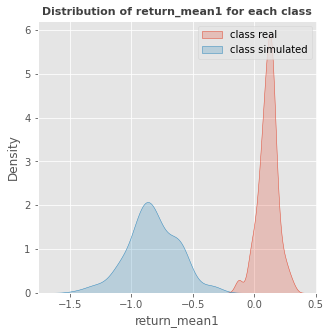

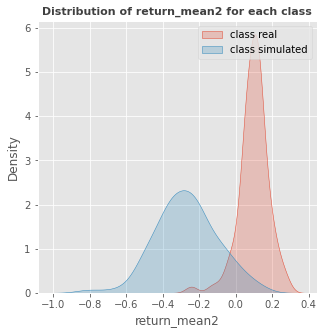

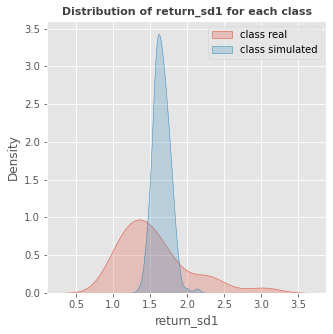

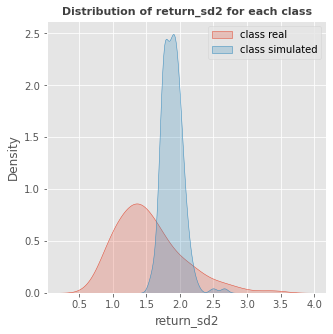

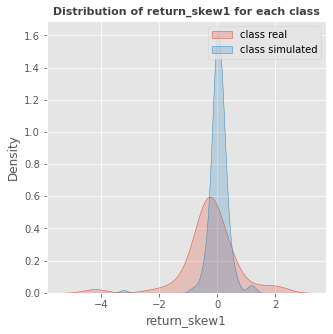

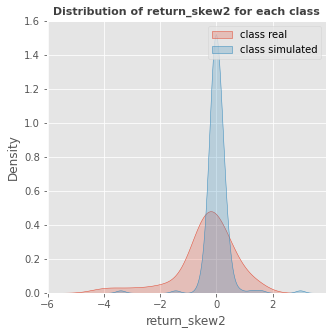

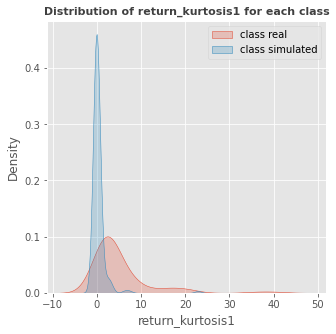

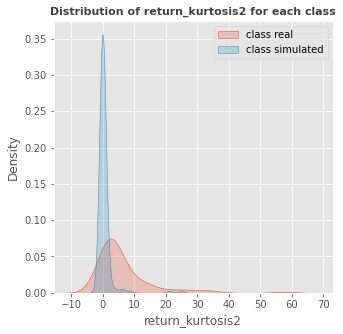

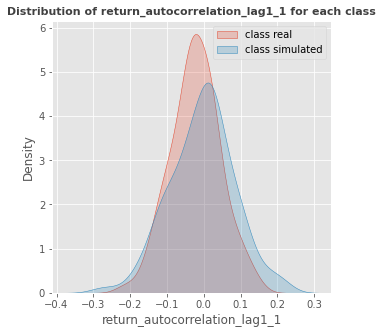

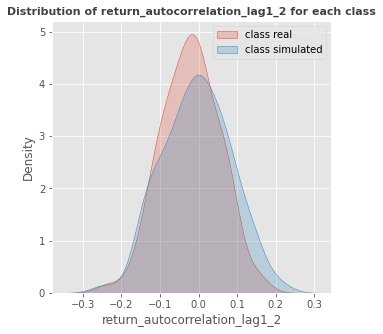

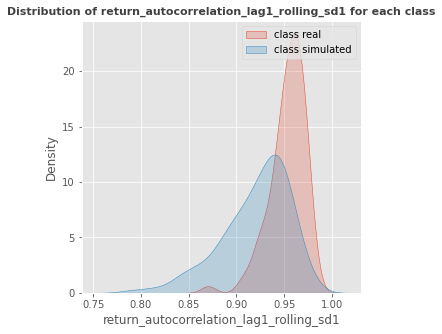

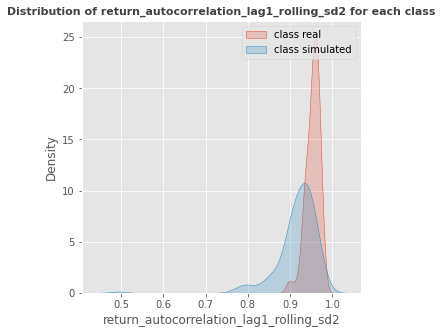

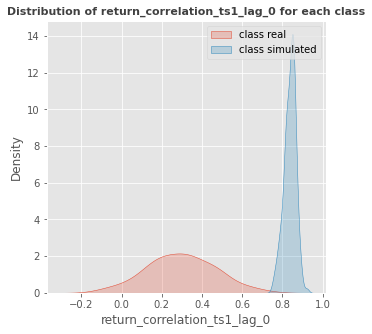

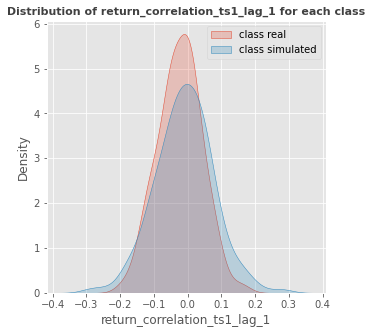

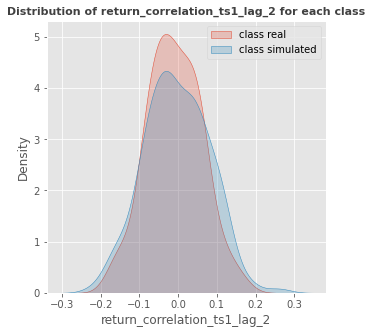

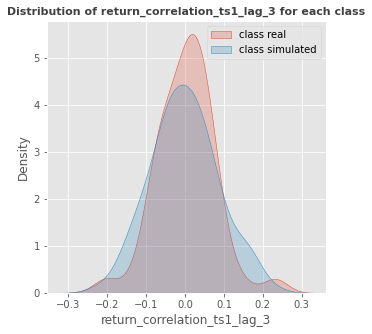

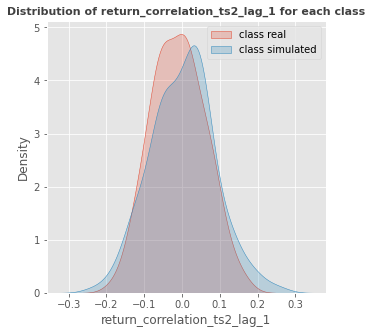

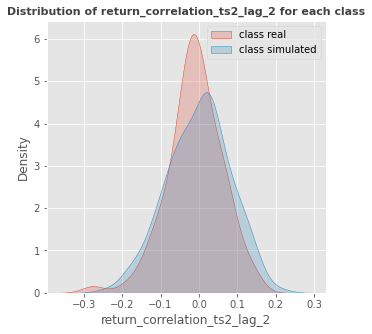

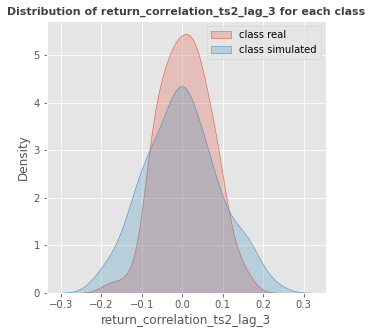

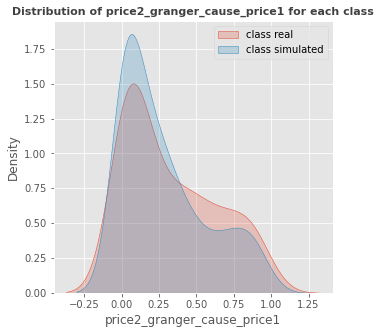

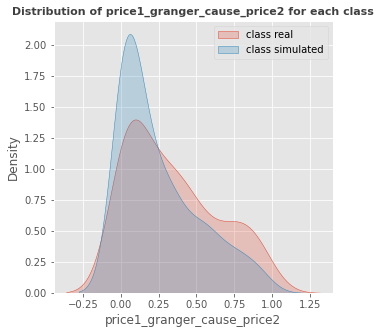

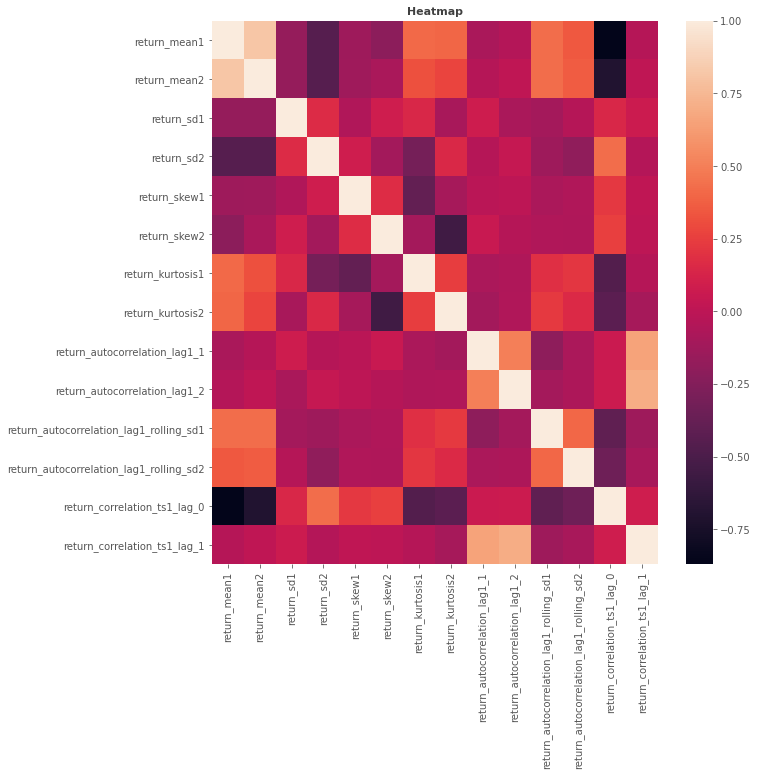

In [4]:
np.random.seed(9868)
num_iter = 5
random_seeds = np.random.randint(low=0, high=980608, size=(num_iter,))
results = []


real_statistics = create_statistics(
    label="real", 
    rolling_window=20, 
    return_csv_location=real_data_folder + "pair_return_mixed_period_classification.csv", 
    price_csv_location=real_data_folder + "pair_price_mixed_period_classification.csv")
real_statistics = real_statistics.iloc[0:124 ,:]
    
    
for iter in range(num_iter):

    random_seed = int(random_seeds[iter])
    
    n_sim_jumpou_log_prices = n_jumpou_simulation(
        random_seed=random_seed, num_sim=248,
        mu11=params[0], mu12=params[1], 
        mu21=params[2], mu22=params[3], 
        sigma11=params[4], sigma12=params[5], 
        sigma21=params[6], sigma22=params[7],
        j11=params[8], j12=params[9], 
        j21=params[10], j22=params[11],
        alpha=alpha, 
        beta1=beta1, beta2=beta2, 
        delta0=params[12], 
        mu1=mu1, mu2=mu2, 
        lambda11=lambda11, lambda12=lambda12, 
        lambda21=lambda21, lambda22=lambda22,
        xinit_vec=xinit_vec, T0=T0, T=T/2, length=length/2)

    n_sim_jumpou_pair_prices = log_price_to_price(n_log_price=n_sim_jumpou_log_prices)
    n_sim_jumpou_pair_returns = price_to_return(n_price=n_sim_jumpou_pair_prices)

    n_sim_jumpou_pair_prices.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/trendingou_jump12/n_sim_jumpou_pair_prices.csv")
    n_sim_jumpou_pair_returns.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/trendingou_jump12/n_sim_jumpou_pair_returns.csv")
    
    
    simulated_statistics = create_statistics(
        label="simulated", 
        rolling_window=20, 
        return_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/trendingou_jump12/n_sim_jumpou_pair_returns.csv", 
        price_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/trendingou_jump12/n_sim_jumpou_pair_prices.csv")


    dataset = pd.concat([real_statistics, simulated_statistics])
    X = dataset.iloc[:, 0:21]
    y = dataset.iloc[:, 21]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)
    automl = AutoML(eval_metric='accuracy')
    automl.fit(X_train, y_train)
    predictions = automl.predict(X_test)
    accuracy_result = accuracy_score(y_test, predictions)
    results.append(accuracy_result)
    EDA.extensive_eda(X_train, y_train, save_path="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/trendingou_jump12/ou_jump12_calibration_update_classification_EDA/AutoML_EDA")
    print(f"Accuracy of predictions:  {accuracy_result:.3f}")

accuracy_average = np.mean(results)
accuracy_std = np.std(results)
print(results)
print(accuracy_average)
print(accuracy_std)